In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
from segtok import tokenizer
from utils import *
import hickle

In [2]:
# Key Hyperparameters
enable_orig = "orig"
enable_aug = False
enable_aug3 = False
max_training_samples = 100000
max_tokenized_length = 64
num_sentences = 10
valid_percent = 0.01

batch_size_finetuning = 32
epochs_finetuning = 1
lr_finetuning = 1e-5

batch_size = 128
epochs = 20
main_model_lr = 1e-5

lstm_hidden_size = 1024
regressive_style_finetuning = False

experiment_id = f"test"

In [3]:
# Parameters
regressive_style_finetuning = True
enable_orig = False
enable_aug = False
enable_aug3 = True
max_training_samples = 200000
lstm_hidden_size = 128
epochs = 20
experiment_id = "classification-sentence-embeddings-regressive_style_finetuning-True-enable_orig-False-enable_aug-False-enable_aug3-True-max_training_samples-200000-lstm_hidden_size-128-epochs-20"


In [4]:
import os
experiment_dir = f"completed-experiments/{experiment_id}"
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

In [5]:
from data_parsing import *
data = load_dataset("./yelp_review_training_dataset.jsonl")

In [6]:
from training_utils import split_train_validation
from text_preprocessing import preprocess
import random

def get_train_valid():
    orig_train_x, valid_x, orig_train_y, valid_y = split_train_validation(data, 0.01)
    train_x = []
    train_y = []

    if enable_aug:
        aug_data = load_gen_dataset("./new_data.json") + load_gen_dataset("./new_data2.json")
        train_x += [i[0] for i in aug_data]
        train_y += [i[1] for i in aug_data]

    if enable_aug3:
        aug_data3 = load_gen_dataset("./new_data3.json")
        train_x += [i[0] for i in aug_data3]
        train_y += [i[1] for i in aug_data3]
        
    if enable_orig:
        train_x += orig_train_x
        train_y += orig_train_y
    
    train_x = train_x[:max_training_samples]
    train_y = train_y[:max_training_samples]

    if enable_orig == "preprocess":
        train_x = preprocess(train_x)
        valid_x = preprocess(valid_x)    

    paired_train = list(zip(train_x, train_y))
    random.shuffle(paired_train)
    train_x = [i[0] for i in paired_train]
    train_y = [i[1] for i in paired_train]

    return [x.encode("utf-8") for x in train_x], [x.encode("utf-8") for x in valid_x], train_y, valid_y

split_key = f"cache-core/split-data-{valid_percent}-orig-{enable_orig}-aug12-{enable_aug}-aug3-{enable_aug3}-max-{max_training_samples}"
train_x, valid_x, train_y, valid_y = memo_load(
    get_train_valid,
    split_key
)
split_hash = hash_file(split_key + ".hkl")

train_x = [x.decode("utf-8") for x in train_x]
valid_x = [x.decode("utf-8") for x in valid_x]

In [7]:
print(len(train_x))
print(len(train_y))
print(len(valid_x))
print(len(valid_y))

5000
5000
5336
5336


In [8]:
import torch as th

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(device)

from spacy.lang.en import English
nlp = English()
nlp.add_pipe("sentencizer")

cuda


In [9]:
from transformers import BertTokenizerFast, BertForSequenceClassification
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [10]:
# fine tune the BERT
import numpy as np

def get_finetuning_data():
    train_x_numerized = []
    train_x_mask = []
    train_y_per_sentence = []
    for i, text in tqdm(list(enumerate(train_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            train_x_numerized.append(tokenized.ids)
            train_x_mask.append(tokenized.attention_mask)
            train_y_per_sentence.append(train_y[i])

    valid_x_numerized = []
    valid_x_mask = []
    valid_y_per_sentence = []
    for i, text in tqdm(list(enumerate(valid_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            valid_x_numerized.append(tokenized.ids)
            valid_x_mask.append(tokenized.attention_mask)
            valid_y_per_sentence.append(valid_y[i])

    train_x_numerized = np.array(train_x_numerized)
    train_x_mask = np.array(train_x_mask)
    train_y_per_sentence = np.array(train_y_per_sentence)
    valid_x_numerized = np.array(valid_x_numerized)
    valid_x_mask = np.array(valid_x_mask)
    valid_y_per_sentence = np.array(valid_y_per_sentence)
    return train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence

from utils import memo_load
finetuning_data_key = f"cache-core/training-data-finetuning-max-tokens-{max_tokenized_length}-split-{split_hash}"
(train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence) = memo_load(
    lambda: get_finetuning_data(),
    finetuning_data_key
)
finetuning_data_hash = hash_file(finetuning_data_key + ".hkl")

In [11]:
from model import ReviewPredictionModel
import torch.optim as optim

def train_finetuning():
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)

    model_to_train_finetuning = ReviewPredictionModel(0, max_tokenized_length, regressive_bert_style=regressive_style_finetuning)
    model_to_train_finetuning.transformer = embedding_bert
    model_to_train_finetuning.to(device)
    optimizer = optim.Adam(model_to_train_finetuning.parameters(), lr=lr_finetuning)
    
    training_accuracies_finetuning, validation_accuracies_finetuning = run_training_loop(
        model_to_train_finetuning, optimizer, device,
        batch_size_finetuning, epochs_finetuning,
        train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence,
        max_validation_examples=256,
        model_id=experiment_id, tag="finetuning"
    )
    
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

def store_finetuning(tup, folder):
    embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = tup
    th.save(embedding_bert.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{folder}/accuracies.hkl", mode="w")

def load_finetuning(folder):
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)
    embedding_bert.load_state_dict(th.load(f"{folder}/model.pt"))
    embedding_bert.eval()
    embedding_bert.to(device)
    training_accuracies_finetuning, validation_accuracies_finetuning = hickle.load(f"{folder}/accuracies.hkl")
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

In [12]:
from training_utils import run_training_loop

from utils import memo_load
finetuning_model_key = f"cache-core/finetuning-batch-size-{batch_size_finetuning}-epochs-{epochs_finetuning}-lr-{lr_finetuning}-regressive-{regressive_style_finetuning}-data-{finetuning_data_hash}"
embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = manual_memo(
    train_finetuning, store_finetuning, load_finetuning,
    finetuning_model_key
)

th.save(embedding_bert.state_dict(), f"{experiment_dir}/finetuned-bert.pt")
hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{experiment_dir}/finetuning-accuracies.hkl", mode="w")

finetuning_model_hash = hash_file(finetuning_model_key + "/model.pt")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


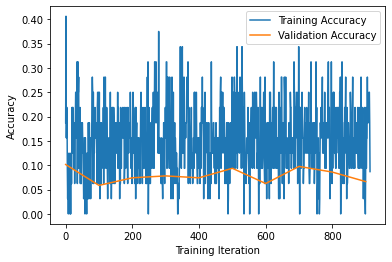

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies_finetuning)), training_accuracies_finetuning, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies_finetuning)))), validation_accuracies_finetuning, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()

In [14]:
import torch as th
import numpy as np

embedding_bert.to(device)

def get_embeds(x_data):
    concatted_shape = None
    pad_value = None
    embeds = []
    for text in tqdm(x_data):
        doc = nlp(text)
        embeddeds = []
        sents = list(doc.sents)
        all_tokenized = []
        for sentence in sents[:num_sentences]:
            sentence = str(sentence)
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            all_tokenized.append(tokenized.ids)
        
        with th.no_grad():
            sentence_tensor = th.tensor(all_tokenized).to(device)
            concatted = np.concatenate([
                # take output corresponding to CLS
                embedding_bert.bert(sentence_tensor, output_hidden_states=True, return_dict=True)[1].cpu().numpy(),
                np.zeros((len(all_tokenized), 1))
            ], axis=1)
            
            if not concatted_shape:
                concatted_shape = concatted.shape
                pad_value = np.zeros(concatted_shape[1])
                pad_value[-1] = 1
            
            embeddeds += list(concatted)

        if len(sents) < num_sentences:
            embeddeds += [pad_value] * (num_sentences - len(sents))

        embeds.append(embeddeds)
    return np.array(embeds)

main_data_key = f"cache-core/training-data-main-max-tokens-{max_tokenized_length}-split-{split_hash}-finetuned-{finetuning_model_hash}"
train_x_embeds, valid_x_embeds = memo_load(
    lambda: (
        get_embeds(train_x),
        get_embeds(valid_x)
    ),
    main_data_key
)
main_data_hash = hash_file(main_data_key + ".hkl")

In [15]:
from model_sentence_lstm import ReviewPredictionModel
import torch as th
import torch.optim as optim

def train_main():
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size)
    model_to_train.to(device)
    optimizer = optim.Adam(model_to_train.parameters(), lr=main_model_lr)
    
    training_accuracies, validation_accuracies = run_training_loop(
        model_to_train, optimizer, device,
        batch_size, epochs,
        train_x_embeds, None, np.array(train_y), valid_x_embeds, None, np.array(valid_y),
        model_id=experiment_id, max_validation_examples=512
    )
    
    return model_to_train, training_accuracies, validation_accuracies

def store_main(tup, folder):
    model_to_train, training_accuracies, validation_accuracies = tup
    th.save(model_to_train.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies, validation_accuracies), f"{folder}/accuracies.hkl", mode="w")

def load_main(folder):
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size)
    model_to_train.load_state_dict(th.load(f"{folder}/model.pt"))
    model_to_train.eval()
    model_to_train.to(device)
    training_accuracies, validation_accuracies = hickle.load(f"{folder}/accuracies.hkl")
    return model_to_train, training_accuracies, validation_accuracies

In [16]:
from training_utils import run_training_loop

main_model_key = f"cache-core/main-model-lstm-{lstm_hidden_size}-lr-{main_model_lr}-batch-size-{batch_size}-epochs-{epochs}-data-{main_data_hash}"
main_model, training_accuracies, validation_accuracies = manual_memo(
    train_main, store_main, load_main,
    main_model_key
)

th.save(main_model.state_dict(), f"{experiment_dir}/main-model.pt")
hickle.dump((training_accuracies, validation_accuracies), f"{experiment_dir}/main-accuracies.hkl", mode="w")

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 0 Loss: 2.189 Validation Loss: 2.149 Accuracy: 0.000 Validation Accuracy: 0.139:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 1 Loss: 2.187 Validation Loss: 2.149 Accuracy: 0.000 Validation Accuracy: 0.139:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 2 Loss: 2.185 Validation Loss: 2.149 Accuracy: 0.000 Validation Accuracy: 0.139:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 3 Loss: 2.186 Validation Loss: 2.149 Accuracy: 0.000 Validation Accuracy: 0.139:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 4 Loss: 2.187 Validation Loss: 2.149 Accuracy: 0.000 Validation Accuracy: 0.139:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 5 Loss: 2.188 Validation Loss: 2.149 Accuracy: 0.000 Validation Accuracy: 0.139:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 6 Loss: 2.187 Validation Loss: 2.149 Accuracy: 0.000 Validation Accuracy: 0.139:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 7 Loss: 2.186 Validation Loss: 2.149 Accuracy: 0.001 Validation Accuracy: 0.139:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 8 Loss: 2.185 Validation Loss: 2.149 Accuracy: 0.004 Validation Accuracy: 0.139:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 9 Loss: 2.184 Validation Loss: 2.149 Accuracy: 0.005 Validation Accuracy: 0.139:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 10 Loss: 2.184 Validation Loss: 2.149 Accuracy: 0.007 Validation Accuracy: 0.139:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 11 Loss: 2.184 Validation Loss: 2.149 Accuracy: 0.013 Validation Accuracy: 0.139:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 12 Loss: 2.184 Validation Loss: 2.149 Accuracy: 0.017 Validation Accuracy: 0.139:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 13 Loss: 2.183 Validation Loss: 2.149 Accuracy: 0.026 Validation Accuracy: 0.139:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 14 Loss: 2.182 Validation Loss: 2.149 Accuracy: 0.034 Validation Accuracy: 0.139:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 15 Loss: 2.182 Validation Loss: 2.149 Accuracy: 0.041 Validation Accuracy: 0.139:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 16 Loss: 2.181 Validation Loss: 2.149 Accuracy: 0.050 Validation Accuracy: 0.139:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 17 Loss: 2.181 Validation Loss: 2.149 Accuracy: 0.061 Validation Accuracy: 0.139:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 18 Loss: 2.180 Validation Loss: 2.149 Accuracy: 0.066 Validation Accuracy: 0.139:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 19 Loss: 2.179 Validation Loss: 2.149 Accuracy: 0.073 Validation Accuracy: 0.139:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 19 Loss: 2.179 Validation Loss: 2.149 Accuracy: 0.073 Validation Accuracy: 0.139:  50%|█████     | 20/40 [00:00<00:00, 193.89it/s]

Epoch: 0 Iteration: 20 Loss: 2.178 Validation Loss: 2.149 Accuracy: 0.087 Validation Accuracy: 0.139:  50%|█████     | 20/40 [00:00<00:00, 193.89it/s]

Epoch: 0 Iteration: 21 Loss: 2.178 Validation Loss: 2.149 Accuracy: 0.094 Validation Accuracy: 0.139:  50%|█████     | 20/40 [00:00<00:00, 193.89it/s]

Epoch: 0 Iteration: 22 Loss: 2.177 Validation Loss: 2.149 Accuracy: 0.109 Validation Accuracy: 0.139:  50%|█████     | 20/40 [00:00<00:00, 193.89it/s]

Epoch: 0 Iteration: 23 Loss: 2.176 Validation Loss: 2.149 Accuracy: 0.119 Validation Accuracy: 0.139:  50%|█████     | 20/40 [00:00<00:00, 193.89it/s]

Epoch: 0 Iteration: 24 Loss: 2.174 Validation Loss: 2.149 Accuracy: 0.123 Validation Accuracy: 0.139:  50%|█████     | 20/40 [00:00<00:00, 193.89it/s]

Epoch: 0 Iteration: 25 Loss: 2.173 Validation Loss: 2.149 Accuracy: 0.129 Validation Accuracy: 0.139:  50%|█████     | 20/40 [00:00<00:00, 193.89it/s]

Epoch: 0 Iteration: 26 Loss: 2.172 Validation Loss: 2.149 Accuracy: 0.141 Validation Accuracy: 0.139:  50%|█████     | 20/40 [00:00<00:00, 193.89it/s]

Epoch: 0 Iteration: 27 Loss: 2.171 Validation Loss: 2.149 Accuracy: 0.145 Validation Accuracy: 0.139:  50%|█████     | 20/40 [00:00<00:00, 193.89it/s]

Epoch: 0 Iteration: 28 Loss: 2.171 Validation Loss: 2.149 Accuracy: 0.155 Validation Accuracy: 0.139:  50%|█████     | 20/40 [00:00<00:00, 193.89it/s]

Epoch: 0 Iteration: 29 Loss: 2.169 Validation Loss: 2.149 Accuracy: 0.168 Validation Accuracy: 0.139:  50%|█████     | 20/40 [00:00<00:00, 193.89it/s]

Epoch: 0 Iteration: 30 Loss: 2.168 Validation Loss: 2.149 Accuracy: 0.177 Validation Accuracy: 0.139:  50%|█████     | 20/40 [00:00<00:00, 193.89it/s]

Epoch: 0 Iteration: 31 Loss: 2.167 Validation Loss: 2.149 Accuracy: 0.188 Validation Accuracy: 0.139:  50%|█████     | 20/40 [00:00<00:00, 193.89it/s]

Epoch: 0 Iteration: 32 Loss: 2.165 Validation Loss: 2.149 Accuracy: 0.197 Validation Accuracy: 0.139:  50%|█████     | 20/40 [00:00<00:00, 193.89it/s]

Epoch: 0 Iteration: 33 Loss: 2.165 Validation Loss: 2.149 Accuracy: 0.202 Validation Accuracy: 0.139:  50%|█████     | 20/40 [00:00<00:00, 193.89it/s]

Epoch: 0 Iteration: 34 Loss: 2.164 Validation Loss: 2.149 Accuracy: 0.220 Validation Accuracy: 0.139:  50%|█████     | 20/40 [00:00<00:00, 193.89it/s]

Epoch: 0 Iteration: 35 Loss: 2.163 Validation Loss: 2.149 Accuracy: 0.234 Validation Accuracy: 0.139:  50%|█████     | 20/40 [00:00<00:00, 193.89it/s]

Epoch: 0 Iteration: 36 Loss: 2.162 Validation Loss: 2.149 Accuracy: 0.241 Validation Accuracy: 0.139:  50%|█████     | 20/40 [00:00<00:00, 193.89it/s]

Epoch: 0 Iteration: 37 Loss: 2.161 Validation Loss: 2.149 Accuracy: 0.263 Validation Accuracy: 0.139:  50%|█████     | 20/40 [00:00<00:00, 193.89it/s]

Epoch: 0 Iteration: 38 Loss: 2.160 Validation Loss: 2.149 Accuracy: 0.280 Validation Accuracy: 0.139:  50%|█████     | 20/40 [00:00<00:00, 193.89it/s]

Epoch: 0 Iteration: 39 Loss: 2.159 Validation Loss: 2.149 Accuracy: 0.259 Validation Accuracy: 0.139:  50%|█████     | 20/40 [00:00<00:00, 193.89it/s]

Epoch: 0 Iteration: 39 Loss: 2.159 Validation Loss: 2.149 Accuracy: 0.259 Validation Accuracy: 0.139: 100%|██████████| 40/40 [00:00<00:00, 205.68it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 0 Loss: 2.158 Validation Loss: 2.151 Accuracy: 0.273 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 1 Loss: 2.157 Validation Loss: 2.151 Accuracy: 0.286 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 2 Loss: 2.156 Validation Loss: 2.151 Accuracy: 0.284 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 3 Loss: 2.155 Validation Loss: 2.151 Accuracy: 0.296 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 4 Loss: 2.154 Validation Loss: 2.151 Accuracy: 0.309 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 5 Loss: 2.153 Validation Loss: 2.151 Accuracy: 0.325 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 6 Loss: 2.152 Validation Loss: 2.151 Accuracy: 0.337 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 7 Loss: 2.151 Validation Loss: 2.151 Accuracy: 0.341 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 8 Loss: 2.149 Validation Loss: 2.151 Accuracy: 0.346 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 9 Loss: 2.148 Validation Loss: 2.151 Accuracy: 0.395 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 10 Loss: 2.147 Validation Loss: 2.151 Accuracy: 0.395 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 11 Loss: 2.146 Validation Loss: 2.151 Accuracy: 0.404 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 12 Loss: 2.146 Validation Loss: 2.151 Accuracy: 0.417 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 13 Loss: 2.144 Validation Loss: 2.151 Accuracy: 0.430 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 14 Loss: 2.144 Validation Loss: 2.151 Accuracy: 0.434 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 15 Loss: 2.143 Validation Loss: 2.151 Accuracy: 0.434 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 16 Loss: 2.142 Validation Loss: 2.151 Accuracy: 0.436 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 17 Loss: 2.141 Validation Loss: 2.151 Accuracy: 0.445 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 18 Loss: 2.141 Validation Loss: 2.151 Accuracy: 0.449 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 19 Loss: 2.140 Validation Loss: 2.151 Accuracy: 0.445 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 20 Loss: 2.139 Validation Loss: 2.151 Accuracy: 0.456 Validation Accuracy: 0.134:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 20 Loss: 2.139 Validation Loss: 2.151 Accuracy: 0.456 Validation Accuracy: 0.134:  52%|█████▎    | 21/40 [00:00<00:00, 201.56it/s]

Epoch: 1 Iteration: 21 Loss: 2.137 Validation Loss: 2.151 Accuracy: 0.469 Validation Accuracy: 0.134:  52%|█████▎    | 21/40 [00:00<00:00, 201.56it/s]

Epoch: 1 Iteration: 22 Loss: 2.135 Validation Loss: 2.151 Accuracy: 0.484 Validation Accuracy: 0.134:  52%|█████▎    | 21/40 [00:00<00:00, 201.56it/s]

Epoch: 1 Iteration: 23 Loss: 2.134 Validation Loss: 2.151 Accuracy: 0.482 Validation Accuracy: 0.134:  52%|█████▎    | 21/40 [00:00<00:00, 201.56it/s]

Epoch: 1 Iteration: 24 Loss: 2.134 Validation Loss: 2.151 Accuracy: 0.480 Validation Accuracy: 0.134:  52%|█████▎    | 21/40 [00:00<00:00, 201.56it/s]

Epoch: 1 Iteration: 25 Loss: 2.133 Validation Loss: 2.151 Accuracy: 0.491 Validation Accuracy: 0.134:  52%|█████▎    | 21/40 [00:00<00:00, 201.56it/s]

Epoch: 1 Iteration: 26 Loss: 2.131 Validation Loss: 2.151 Accuracy: 0.497 Validation Accuracy: 0.134:  52%|█████▎    | 21/40 [00:00<00:00, 201.56it/s]

Epoch: 1 Iteration: 27 Loss: 2.130 Validation Loss: 2.151 Accuracy: 0.498 Validation Accuracy: 0.134:  52%|█████▎    | 21/40 [00:00<00:00, 201.56it/s]

Epoch: 1 Iteration: 28 Loss: 2.129 Validation Loss: 2.151 Accuracy: 0.507 Validation Accuracy: 0.134:  52%|█████▎    | 21/40 [00:00<00:00, 201.56it/s]

Epoch: 1 Iteration: 29 Loss: 2.129 Validation Loss: 2.151 Accuracy: 0.515 Validation Accuracy: 0.134:  52%|█████▎    | 21/40 [00:00<00:00, 201.56it/s]

Epoch: 1 Iteration: 30 Loss: 2.128 Validation Loss: 2.151 Accuracy: 0.512 Validation Accuracy: 0.134:  52%|█████▎    | 21/40 [00:00<00:00, 201.56it/s]

Epoch: 1 Iteration: 31 Loss: 2.127 Validation Loss: 2.151 Accuracy: 0.502 Validation Accuracy: 0.134:  52%|█████▎    | 21/40 [00:00<00:00, 201.56it/s]

Epoch: 1 Iteration: 32 Loss: 2.125 Validation Loss: 2.151 Accuracy: 0.503 Validation Accuracy: 0.134:  52%|█████▎    | 21/40 [00:00<00:00, 201.56it/s]

Epoch: 1 Iteration: 33 Loss: 2.124 Validation Loss: 2.151 Accuracy: 0.516 Validation Accuracy: 0.134:  52%|█████▎    | 21/40 [00:00<00:00, 201.56it/s]

Epoch: 1 Iteration: 34 Loss: 2.123 Validation Loss: 2.151 Accuracy: 0.520 Validation Accuracy: 0.134:  52%|█████▎    | 21/40 [00:00<00:00, 201.56it/s]

Epoch: 1 Iteration: 35 Loss: 2.123 Validation Loss: 2.151 Accuracy: 0.518 Validation Accuracy: 0.134:  52%|█████▎    | 21/40 [00:00<00:00, 201.56it/s]

Epoch: 1 Iteration: 36 Loss: 2.121 Validation Loss: 2.151 Accuracy: 0.517 Validation Accuracy: 0.134:  52%|█████▎    | 21/40 [00:00<00:00, 201.56it/s]

Epoch: 1 Iteration: 37 Loss: 2.120 Validation Loss: 2.151 Accuracy: 0.520 Validation Accuracy: 0.134:  52%|█████▎    | 21/40 [00:00<00:00, 201.56it/s]

Epoch: 1 Iteration: 38 Loss: 2.119 Validation Loss: 2.151 Accuracy: 0.513 Validation Accuracy: 0.134:  52%|█████▎    | 21/40 [00:00<00:00, 201.56it/s]

Epoch: 1 Iteration: 39 Loss: 2.121 Validation Loss: 2.151 Accuracy: 0.498 Validation Accuracy: 0.134:  52%|█████▎    | 21/40 [00:00<00:00, 201.56it/s]

Epoch: 1 Iteration: 39 Loss: 2.121 Validation Loss: 2.151 Accuracy: 0.498 Validation Accuracy: 0.134: 100%|██████████| 40/40 [00:00<00:00, 213.19it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 0 Loss: 2.120 Validation Loss: 2.154 Accuracy: 0.500 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 1 Loss: 2.119 Validation Loss: 2.154 Accuracy: 0.508 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 2 Loss: 2.118 Validation Loss: 2.154 Accuracy: 0.505 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 3 Loss: 2.117 Validation Loss: 2.154 Accuracy: 0.494 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 4 Loss: 2.115 Validation Loss: 2.154 Accuracy: 0.494 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 5 Loss: 2.114 Validation Loss: 2.154 Accuracy: 0.496 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 6 Loss: 2.114 Validation Loss: 2.154 Accuracy: 0.494 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 7 Loss: 2.112 Validation Loss: 2.154 Accuracy: 0.494 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 8 Loss: 2.112 Validation Loss: 2.154 Accuracy: 0.499 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 9 Loss: 2.112 Validation Loss: 2.154 Accuracy: 0.512 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 10 Loss: 2.110 Validation Loss: 2.154 Accuracy: 0.519 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 11 Loss: 2.108 Validation Loss: 2.154 Accuracy: 0.516 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 12 Loss: 2.108 Validation Loss: 2.154 Accuracy: 0.514 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 13 Loss: 2.108 Validation Loss: 2.154 Accuracy: 0.516 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 14 Loss: 2.107 Validation Loss: 2.154 Accuracy: 0.524 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 15 Loss: 2.106 Validation Loss: 2.154 Accuracy: 0.515 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 16 Loss: 2.105 Validation Loss: 2.154 Accuracy: 0.517 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 17 Loss: 2.104 Validation Loss: 2.154 Accuracy: 0.511 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 18 Loss: 2.103 Validation Loss: 2.154 Accuracy: 0.509 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 19 Loss: 2.099 Validation Loss: 2.154 Accuracy: 0.508 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 20 Loss: 2.099 Validation Loss: 2.154 Accuracy: 0.498 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 20 Loss: 2.099 Validation Loss: 2.154 Accuracy: 0.498 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 208.15it/s]

Epoch: 2 Iteration: 21 Loss: 2.098 Validation Loss: 2.154 Accuracy: 0.496 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 208.15it/s]

Epoch: 2 Iteration: 22 Loss: 2.096 Validation Loss: 2.154 Accuracy: 0.507 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 208.15it/s]

Epoch: 2 Iteration: 23 Loss: 2.096 Validation Loss: 2.154 Accuracy: 0.505 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 208.15it/s]

Epoch: 2 Iteration: 24 Loss: 2.095 Validation Loss: 2.154 Accuracy: 0.495 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 208.15it/s]

Epoch: 2 Iteration: 25 Loss: 2.095 Validation Loss: 2.154 Accuracy: 0.495 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 208.15it/s]

Epoch: 2 Iteration: 26 Loss: 2.093 Validation Loss: 2.154 Accuracy: 0.493 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 208.15it/s]

Epoch: 2 Iteration: 27 Loss: 2.094 Validation Loss: 2.154 Accuracy: 0.491 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 208.15it/s]

Epoch: 2 Iteration: 28 Loss: 2.093 Validation Loss: 2.154 Accuracy: 0.486 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 208.15it/s]

Epoch: 2 Iteration: 29 Loss: 2.092 Validation Loss: 2.154 Accuracy: 0.492 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 208.15it/s]

Epoch: 2 Iteration: 30 Loss: 2.091 Validation Loss: 2.154 Accuracy: 0.497 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 208.15it/s]

Epoch: 2 Iteration: 31 Loss: 2.090 Validation Loss: 2.154 Accuracy: 0.492 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 208.15it/s]

Epoch: 2 Iteration: 32 Loss: 2.088 Validation Loss: 2.154 Accuracy: 0.477 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 208.15it/s]

Epoch: 2 Iteration: 33 Loss: 2.087 Validation Loss: 2.154 Accuracy: 0.477 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 208.15it/s]

Epoch: 2 Iteration: 34 Loss: 2.087 Validation Loss: 2.154 Accuracy: 0.473 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 208.15it/s]

Epoch: 2 Iteration: 35 Loss: 2.085 Validation Loss: 2.154 Accuracy: 0.480 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 208.15it/s]

Epoch: 2 Iteration: 36 Loss: 2.084 Validation Loss: 2.154 Accuracy: 0.487 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 208.15it/s]

Epoch: 2 Iteration: 37 Loss: 2.082 Validation Loss: 2.154 Accuracy: 0.498 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 208.15it/s]

Epoch: 2 Iteration: 38 Loss: 2.081 Validation Loss: 2.154 Accuracy: 0.504 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 208.15it/s]

Epoch: 2 Iteration: 39 Loss: 2.077 Validation Loss: 2.154 Accuracy: 0.536 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 208.15it/s]

Epoch: 2 Iteration: 39 Loss: 2.077 Validation Loss: 2.154 Accuracy: 0.536 Validation Accuracy: 0.136: 100%|██████████| 40/40 [00:00<00:00, 217.13it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 0 Loss: 2.077 Validation Loss: 2.160 Accuracy: 0.534 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 1 Loss: 2.075 Validation Loss: 2.160 Accuracy: 0.538 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 2 Loss: 2.075 Validation Loss: 2.160 Accuracy: 0.537 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 3 Loss: 2.074 Validation Loss: 2.160 Accuracy: 0.534 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 4 Loss: 2.073 Validation Loss: 2.160 Accuracy: 0.540 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 5 Loss: 2.071 Validation Loss: 2.160 Accuracy: 0.541 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 6 Loss: 2.070 Validation Loss: 2.160 Accuracy: 0.537 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 7 Loss: 2.067 Validation Loss: 2.160 Accuracy: 0.541 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 8 Loss: 2.066 Validation Loss: 2.160 Accuracy: 0.532 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 9 Loss: 2.065 Validation Loss: 2.160 Accuracy: 0.494 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 10 Loss: 2.065 Validation Loss: 2.160 Accuracy: 0.495 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 11 Loss: 2.062 Validation Loss: 2.160 Accuracy: 0.497 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 12 Loss: 2.064 Validation Loss: 2.160 Accuracy: 0.497 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 13 Loss: 2.061 Validation Loss: 2.160 Accuracy: 0.498 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 14 Loss: 2.057 Validation Loss: 2.160 Accuracy: 0.502 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 15 Loss: 2.057 Validation Loss: 2.160 Accuracy: 0.493 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 16 Loss: 2.056 Validation Loss: 2.160 Accuracy: 0.497 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 17 Loss: 2.055 Validation Loss: 2.160 Accuracy: 0.491 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 18 Loss: 2.055 Validation Loss: 2.160 Accuracy: 0.498 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 19 Loss: 2.057 Validation Loss: 2.160 Accuracy: 0.494 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 20 Loss: 2.054 Validation Loss: 2.160 Accuracy: 0.505 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 20 Loss: 2.054 Validation Loss: 2.160 Accuracy: 0.505 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 207.07it/s]

Epoch: 3 Iteration: 21 Loss: 2.054 Validation Loss: 2.160 Accuracy: 0.503 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 207.07it/s]

Epoch: 3 Iteration: 22 Loss: 2.053 Validation Loss: 2.160 Accuracy: 0.509 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 207.07it/s]

Epoch: 3 Iteration: 23 Loss: 2.052 Validation Loss: 2.160 Accuracy: 0.510 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 207.07it/s]

Epoch: 3 Iteration: 24 Loss: 2.050 Validation Loss: 2.160 Accuracy: 0.512 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 207.07it/s]

Epoch: 3 Iteration: 25 Loss: 2.049 Validation Loss: 2.160 Accuracy: 0.521 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 207.07it/s]

Epoch: 3 Iteration: 26 Loss: 2.048 Validation Loss: 2.160 Accuracy: 0.521 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 207.07it/s]

Epoch: 3 Iteration: 27 Loss: 2.048 Validation Loss: 2.160 Accuracy: 0.517 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 207.07it/s]

Epoch: 3 Iteration: 28 Loss: 2.047 Validation Loss: 2.160 Accuracy: 0.523 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 207.07it/s]

Epoch: 3 Iteration: 29 Loss: 2.047 Validation Loss: 2.160 Accuracy: 0.528 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 207.07it/s]

Epoch: 3 Iteration: 30 Loss: 2.046 Validation Loss: 2.160 Accuracy: 0.518 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 207.07it/s]

Epoch: 3 Iteration: 31 Loss: 2.046 Validation Loss: 2.160 Accuracy: 0.519 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 207.07it/s]

Epoch: 3 Iteration: 32 Loss: 2.042 Validation Loss: 2.160 Accuracy: 0.515 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 207.07it/s]

Epoch: 3 Iteration: 33 Loss: 2.043 Validation Loss: 2.160 Accuracy: 0.515 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 207.07it/s]

Epoch: 3 Iteration: 34 Loss: 2.043 Validation Loss: 2.160 Accuracy: 0.509 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 207.07it/s]

Epoch: 3 Iteration: 35 Loss: 2.041 Validation Loss: 2.160 Accuracy: 0.505 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 207.07it/s]

Epoch: 3 Iteration: 36 Loss: 2.041 Validation Loss: 2.160 Accuracy: 0.503 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 207.07it/s]

Epoch: 3 Iteration: 37 Loss: 2.041 Validation Loss: 2.160 Accuracy: 0.507 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 207.07it/s]

Epoch: 3 Iteration: 38 Loss: 2.040 Validation Loss: 2.160 Accuracy: 0.496 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 207.07it/s]

Epoch: 3 Iteration: 39 Loss: 2.037 Validation Loss: 2.160 Accuracy: 0.509 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 207.07it/s]

Epoch: 3 Iteration: 39 Loss: 2.037 Validation Loss: 2.160 Accuracy: 0.509 Validation Accuracy: 0.136: 100%|██████████| 40/40 [00:00<00:00, 216.97it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 0 Loss: 2.038 Validation Loss: 2.171 Accuracy: 0.508 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 1 Loss: 2.037 Validation Loss: 2.171 Accuracy: 0.503 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 2 Loss: 2.035 Validation Loss: 2.171 Accuracy: 0.516 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 3 Loss: 2.034 Validation Loss: 2.171 Accuracy: 0.516 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 4 Loss: 2.035 Validation Loss: 2.171 Accuracy: 0.517 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 5 Loss: 2.033 Validation Loss: 2.171 Accuracy: 0.518 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 6 Loss: 2.031 Validation Loss: 2.171 Accuracy: 0.521 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 7 Loss: 2.030 Validation Loss: 2.171 Accuracy: 0.527 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 8 Loss: 2.028 Validation Loss: 2.171 Accuracy: 0.530 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 9 Loss: 2.025 Validation Loss: 2.171 Accuracy: 0.520 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 10 Loss: 2.023 Validation Loss: 2.171 Accuracy: 0.522 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 11 Loss: 2.021 Validation Loss: 2.171 Accuracy: 0.532 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 12 Loss: 2.021 Validation Loss: 2.171 Accuracy: 0.522 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 13 Loss: 2.018 Validation Loss: 2.171 Accuracy: 0.523 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 14 Loss: 2.017 Validation Loss: 2.171 Accuracy: 0.521 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 15 Loss: 2.016 Validation Loss: 2.171 Accuracy: 0.525 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 16 Loss: 2.015 Validation Loss: 2.171 Accuracy: 0.523 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 17 Loss: 2.015 Validation Loss: 2.171 Accuracy: 0.509 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 18 Loss: 2.013 Validation Loss: 2.171 Accuracy: 0.503 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 19 Loss: 2.012 Validation Loss: 2.171 Accuracy: 0.496 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 20 Loss: 2.008 Validation Loss: 2.171 Accuracy: 0.505 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 20 Loss: 2.008 Validation Loss: 2.171 Accuracy: 0.505 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 206.60it/s]

Epoch: 4 Iteration: 21 Loss: 2.008 Validation Loss: 2.171 Accuracy: 0.500 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 206.60it/s]

Epoch: 4 Iteration: 22 Loss: 2.009 Validation Loss: 2.171 Accuracy: 0.496 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 206.60it/s]

Epoch: 4 Iteration: 23 Loss: 2.007 Validation Loss: 2.171 Accuracy: 0.495 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 206.60it/s]

Epoch: 4 Iteration: 24 Loss: 2.005 Validation Loss: 2.171 Accuracy: 0.488 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 206.60it/s]

Epoch: 4 Iteration: 25 Loss: 2.004 Validation Loss: 2.171 Accuracy: 0.482 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 206.60it/s]

Epoch: 4 Iteration: 26 Loss: 2.004 Validation Loss: 2.171 Accuracy: 0.482 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 206.60it/s]

Epoch: 4 Iteration: 27 Loss: 2.002 Validation Loss: 2.171 Accuracy: 0.490 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 206.60it/s]

Epoch: 4 Iteration: 28 Loss: 2.002 Validation Loss: 2.171 Accuracy: 0.494 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 206.60it/s]

Epoch: 4 Iteration: 29 Loss: 2.002 Validation Loss: 2.171 Accuracy: 0.504 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 206.60it/s]

Epoch: 4 Iteration: 30 Loss: 2.002 Validation Loss: 2.171 Accuracy: 0.495 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 206.60it/s]

Epoch: 4 Iteration: 31 Loss: 2.004 Validation Loss: 2.171 Accuracy: 0.492 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 206.60it/s]

Epoch: 4 Iteration: 32 Loss: 2.003 Validation Loss: 2.171 Accuracy: 0.498 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 206.60it/s]

Epoch: 4 Iteration: 33 Loss: 2.003 Validation Loss: 2.171 Accuracy: 0.498 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 206.60it/s]

Epoch: 4 Iteration: 34 Loss: 2.001 Validation Loss: 2.171 Accuracy: 0.504 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 206.60it/s]

Epoch: 4 Iteration: 35 Loss: 2.000 Validation Loss: 2.171 Accuracy: 0.512 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 206.60it/s]

Epoch: 4 Iteration: 36 Loss: 1.999 Validation Loss: 2.171 Accuracy: 0.505 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 206.60it/s]

Epoch: 4 Iteration: 37 Loss: 1.996 Validation Loss: 2.171 Accuracy: 0.499 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 206.60it/s]

Epoch: 4 Iteration: 38 Loss: 1.993 Validation Loss: 2.171 Accuracy: 0.498 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 206.60it/s]

Epoch: 4 Iteration: 39 Loss: 1.991 Validation Loss: 2.171 Accuracy: 0.481 Validation Accuracy: 0.136:  52%|█████▎    | 21/40 [00:00<00:00, 206.60it/s]

Epoch: 4 Iteration: 39 Loss: 1.991 Validation Loss: 2.171 Accuracy: 0.481 Validation Accuracy: 0.136: 100%|██████████| 40/40 [00:00<00:00, 216.40it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 0 Loss: 1.991 Validation Loss: 2.187 Accuracy: 0.474 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 1 Loss: 1.991 Validation Loss: 2.187 Accuracy: 0.476 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 2 Loss: 1.988 Validation Loss: 2.187 Accuracy: 0.478 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 3 Loss: 1.987 Validation Loss: 2.187 Accuracy: 0.478 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 4 Loss: 1.986 Validation Loss: 2.187 Accuracy: 0.484 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 5 Loss: 1.985 Validation Loss: 2.187 Accuracy: 0.482 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 6 Loss: 1.982 Validation Loss: 2.187 Accuracy: 0.494 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 7 Loss: 1.981 Validation Loss: 2.187 Accuracy: 0.492 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 8 Loss: 1.980 Validation Loss: 2.187 Accuracy: 0.496 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 9 Loss: 1.976 Validation Loss: 2.187 Accuracy: 0.516 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 10 Loss: 1.975 Validation Loss: 2.187 Accuracy: 0.523 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 11 Loss: 1.969 Validation Loss: 2.187 Accuracy: 0.523 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 12 Loss: 1.968 Validation Loss: 2.187 Accuracy: 0.521 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 13 Loss: 1.967 Validation Loss: 2.187 Accuracy: 0.519 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 14 Loss: 1.969 Validation Loss: 2.187 Accuracy: 0.505 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 15 Loss: 1.968 Validation Loss: 2.187 Accuracy: 0.505 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 16 Loss: 1.966 Validation Loss: 2.187 Accuracy: 0.507 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 17 Loss: 1.963 Validation Loss: 2.187 Accuracy: 0.508 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 18 Loss: 1.965 Validation Loss: 2.187 Accuracy: 0.498 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 19 Loss: 1.965 Validation Loss: 2.187 Accuracy: 0.488 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 20 Loss: 1.962 Validation Loss: 2.187 Accuracy: 0.490 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 20 Loss: 1.962 Validation Loss: 2.187 Accuracy: 0.490 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 201.92it/s]

Epoch: 5 Iteration: 21 Loss: 1.957 Validation Loss: 2.187 Accuracy: 0.496 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 201.92it/s]

Epoch: 5 Iteration: 22 Loss: 1.956 Validation Loss: 2.187 Accuracy: 0.494 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 201.92it/s]

Epoch: 5 Iteration: 23 Loss: 1.954 Validation Loss: 2.187 Accuracy: 0.499 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 201.92it/s]

Epoch: 5 Iteration: 24 Loss: 1.952 Validation Loss: 2.187 Accuracy: 0.511 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 201.92it/s]

Epoch: 5 Iteration: 25 Loss: 1.953 Validation Loss: 2.187 Accuracy: 0.505 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 201.92it/s]

Epoch: 5 Iteration: 26 Loss: 1.954 Validation Loss: 2.187 Accuracy: 0.501 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 201.92it/s]

Epoch: 5 Iteration: 27 Loss: 1.951 Validation Loss: 2.187 Accuracy: 0.502 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 201.92it/s]

Epoch: 5 Iteration: 28 Loss: 1.950 Validation Loss: 2.187 Accuracy: 0.505 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 201.92it/s]

Epoch: 5 Iteration: 29 Loss: 1.950 Validation Loss: 2.187 Accuracy: 0.503 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 201.92it/s]

Epoch: 5 Iteration: 30 Loss: 1.950 Validation Loss: 2.187 Accuracy: 0.498 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 201.92it/s]

Epoch: 5 Iteration: 31 Loss: 1.950 Validation Loss: 2.187 Accuracy: 0.491 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 201.92it/s]

Epoch: 5 Iteration: 32 Loss: 1.950 Validation Loss: 2.187 Accuracy: 0.491 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 201.92it/s]

Epoch: 5 Iteration: 33 Loss: 1.947 Validation Loss: 2.187 Accuracy: 0.492 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 201.92it/s]

Epoch: 5 Iteration: 34 Loss: 1.945 Validation Loss: 2.187 Accuracy: 0.485 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 201.92it/s]

Epoch: 5 Iteration: 35 Loss: 1.945 Validation Loss: 2.187 Accuracy: 0.491 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 201.92it/s]

Epoch: 5 Iteration: 36 Loss: 1.944 Validation Loss: 2.187 Accuracy: 0.487 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 201.92it/s]

Epoch: 5 Iteration: 37 Loss: 1.945 Validation Loss: 2.187 Accuracy: 0.491 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 201.92it/s]

Epoch: 5 Iteration: 38 Loss: 1.943 Validation Loss: 2.187 Accuracy: 0.502 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 201.92it/s]

Epoch: 5 Iteration: 39 Loss: 1.941 Validation Loss: 2.187 Accuracy: 0.493 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 201.92it/s]

Epoch: 5 Iteration: 39 Loss: 1.941 Validation Loss: 2.187 Accuracy: 0.493 Validation Accuracy: 0.135: 100%|██████████| 40/40 [00:00<00:00, 208.82it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 0 Loss: 1.941 Validation Loss: 2.210 Accuracy: 0.492 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 1 Loss: 1.944 Validation Loss: 2.210 Accuracy: 0.491 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 2 Loss: 1.942 Validation Loss: 2.210 Accuracy: 0.494 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 3 Loss: 1.942 Validation Loss: 2.210 Accuracy: 0.489 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 4 Loss: 1.940 Validation Loss: 2.210 Accuracy: 0.491 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 5 Loss: 1.938 Validation Loss: 2.210 Accuracy: 0.487 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 6 Loss: 1.937 Validation Loss: 2.210 Accuracy: 0.485 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 7 Loss: 1.936 Validation Loss: 2.210 Accuracy: 0.495 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 8 Loss: 1.934 Validation Loss: 2.210 Accuracy: 0.485 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 9 Loss: 1.932 Validation Loss: 2.210 Accuracy: 0.493 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 10 Loss: 1.931 Validation Loss: 2.210 Accuracy: 0.494 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 11 Loss: 1.931 Validation Loss: 2.210 Accuracy: 0.491 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 12 Loss: 1.929 Validation Loss: 2.210 Accuracy: 0.486 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 13 Loss: 1.929 Validation Loss: 2.210 Accuracy: 0.487 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 14 Loss: 1.927 Validation Loss: 2.210 Accuracy: 0.491 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 15 Loss: 1.924 Validation Loss: 2.210 Accuracy: 0.486 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 16 Loss: 1.921 Validation Loss: 2.210 Accuracy: 0.498 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 17 Loss: 1.917 Validation Loss: 2.210 Accuracy: 0.490 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 18 Loss: 1.916 Validation Loss: 2.210 Accuracy: 0.498 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 18 Loss: 1.916 Validation Loss: 2.210 Accuracy: 0.498 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.29it/s]

Epoch: 6 Iteration: 19 Loss: 1.916 Validation Loss: 2.210 Accuracy: 0.504 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.29it/s]

Epoch: 6 Iteration: 20 Loss: 1.913 Validation Loss: 2.210 Accuracy: 0.509 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.29it/s]

Epoch: 6 Iteration: 21 Loss: 1.911 Validation Loss: 2.210 Accuracy: 0.518 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.29it/s]

Epoch: 6 Iteration: 22 Loss: 1.910 Validation Loss: 2.210 Accuracy: 0.523 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.29it/s]

Epoch: 6 Iteration: 23 Loss: 1.909 Validation Loss: 2.210 Accuracy: 0.522 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.29it/s]

Epoch: 6 Iteration: 24 Loss: 1.909 Validation Loss: 2.210 Accuracy: 0.520 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.29it/s]

Epoch: 6 Iteration: 25 Loss: 1.908 Validation Loss: 2.210 Accuracy: 0.527 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.29it/s]

Epoch: 6 Iteration: 26 Loss: 1.906 Validation Loss: 2.210 Accuracy: 0.516 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.29it/s]

Epoch: 6 Iteration: 27 Loss: 1.907 Validation Loss: 2.210 Accuracy: 0.518 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.29it/s]

Epoch: 6 Iteration: 28 Loss: 1.905 Validation Loss: 2.210 Accuracy: 0.512 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.29it/s]

Epoch: 6 Iteration: 29 Loss: 1.903 Validation Loss: 2.210 Accuracy: 0.515 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.29it/s]

Epoch: 6 Iteration: 30 Loss: 1.898 Validation Loss: 2.210 Accuracy: 0.520 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.29it/s]

Epoch: 6 Iteration: 31 Loss: 1.897 Validation Loss: 2.210 Accuracy: 0.509 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.29it/s]

Epoch: 6 Iteration: 32 Loss: 1.894 Validation Loss: 2.210 Accuracy: 0.505 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.29it/s]

Epoch: 6 Iteration: 33 Loss: 1.892 Validation Loss: 2.210 Accuracy: 0.509 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.29it/s]

Epoch: 6 Iteration: 34 Loss: 1.890 Validation Loss: 2.210 Accuracy: 0.505 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.29it/s]

Epoch: 6 Iteration: 35 Loss: 1.888 Validation Loss: 2.210 Accuracy: 0.503 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.29it/s]

Epoch: 6 Iteration: 36 Loss: 1.889 Validation Loss: 2.210 Accuracy: 0.509 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.29it/s]

Epoch: 6 Iteration: 37 Loss: 1.887 Validation Loss: 2.210 Accuracy: 0.508 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.29it/s]

Epoch: 6 Iteration: 38 Loss: 1.887 Validation Loss: 2.210 Accuracy: 0.504 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.29it/s]

Epoch: 6 Iteration: 39 Loss: 1.882 Validation Loss: 2.210 Accuracy: 0.512 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.29it/s]

Epoch: 6 Iteration: 39 Loss: 1.882 Validation Loss: 2.210 Accuracy: 0.512 Validation Accuracy: 0.135: 100%|██████████| 40/40 [00:00<00:00, 199.55it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 0 Loss: 1.882 Validation Loss: 2.237 Accuracy: 0.511 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 1 Loss: 1.880 Validation Loss: 2.237 Accuracy: 0.517 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 2 Loss: 1.880 Validation Loss: 2.237 Accuracy: 0.519 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 3 Loss: 1.877 Validation Loss: 2.237 Accuracy: 0.517 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 4 Loss: 1.874 Validation Loss: 2.237 Accuracy: 0.523 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 5 Loss: 1.871 Validation Loss: 2.237 Accuracy: 0.524 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 6 Loss: 1.869 Validation Loss: 2.237 Accuracy: 0.523 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 7 Loss: 1.867 Validation Loss: 2.237 Accuracy: 0.518 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 8 Loss: 1.868 Validation Loss: 2.237 Accuracy: 0.517 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 9 Loss: 1.867 Validation Loss: 2.237 Accuracy: 0.506 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 10 Loss: 1.870 Validation Loss: 2.237 Accuracy: 0.507 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 11 Loss: 1.869 Validation Loss: 2.237 Accuracy: 0.516 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 12 Loss: 1.867 Validation Loss: 2.237 Accuracy: 0.515 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 13 Loss: 1.865 Validation Loss: 2.237 Accuracy: 0.513 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 14 Loss: 1.865 Validation Loss: 2.237 Accuracy: 0.505 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 15 Loss: 1.863 Validation Loss: 2.237 Accuracy: 0.508 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 16 Loss: 1.862 Validation Loss: 2.237 Accuracy: 0.502 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 17 Loss: 1.862 Validation Loss: 2.237 Accuracy: 0.508 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 17 Loss: 1.862 Validation Loss: 2.237 Accuracy: 0.508 Validation Accuracy: 0.135:  45%|████▌     | 18/40 [00:00<00:00, 172.84it/s]

Epoch: 7 Iteration: 18 Loss: 1.857 Validation Loss: 2.237 Accuracy: 0.517 Validation Accuracy: 0.135:  45%|████▌     | 18/40 [00:00<00:00, 172.84it/s]

Epoch: 7 Iteration: 19 Loss: 1.860 Validation Loss: 2.237 Accuracy: 0.510 Validation Accuracy: 0.135:  45%|████▌     | 18/40 [00:00<00:00, 172.84it/s]

Epoch: 7 Iteration: 20 Loss: 1.860 Validation Loss: 2.237 Accuracy: 0.500 Validation Accuracy: 0.135:  45%|████▌     | 18/40 [00:00<00:00, 172.84it/s]

Epoch: 7 Iteration: 21 Loss: 1.857 Validation Loss: 2.237 Accuracy: 0.490 Validation Accuracy: 0.135:  45%|████▌     | 18/40 [00:00<00:00, 172.84it/s]

Epoch: 7 Iteration: 22 Loss: 1.853 Validation Loss: 2.237 Accuracy: 0.493 Validation Accuracy: 0.135:  45%|████▌     | 18/40 [00:00<00:00, 172.84it/s]

Epoch: 7 Iteration: 23 Loss: 1.853 Validation Loss: 2.237 Accuracy: 0.497 Validation Accuracy: 0.135:  45%|████▌     | 18/40 [00:00<00:00, 172.84it/s]

Epoch: 7 Iteration: 24 Loss: 1.852 Validation Loss: 2.237 Accuracy: 0.497 Validation Accuracy: 0.135:  45%|████▌     | 18/40 [00:00<00:00, 172.84it/s]

Epoch: 7 Iteration: 25 Loss: 1.853 Validation Loss: 2.237 Accuracy: 0.489 Validation Accuracy: 0.135:  45%|████▌     | 18/40 [00:00<00:00, 172.84it/s]

Epoch: 7 Iteration: 26 Loss: 1.854 Validation Loss: 2.237 Accuracy: 0.488 Validation Accuracy: 0.135:  45%|████▌     | 18/40 [00:00<00:00, 172.84it/s]

Epoch: 7 Iteration: 27 Loss: 1.852 Validation Loss: 2.237 Accuracy: 0.487 Validation Accuracy: 0.135:  45%|████▌     | 18/40 [00:00<00:00, 172.84it/s]

Epoch: 7 Iteration: 28 Loss: 1.848 Validation Loss: 2.237 Accuracy: 0.487 Validation Accuracy: 0.135:  45%|████▌     | 18/40 [00:00<00:00, 172.84it/s]

Epoch: 7 Iteration: 29 Loss: 1.850 Validation Loss: 2.237 Accuracy: 0.483 Validation Accuracy: 0.135:  45%|████▌     | 18/40 [00:00<00:00, 172.84it/s]

Epoch: 7 Iteration: 30 Loss: 1.847 Validation Loss: 2.237 Accuracy: 0.485 Validation Accuracy: 0.135:  45%|████▌     | 18/40 [00:00<00:00, 172.84it/s]

Epoch: 7 Iteration: 31 Loss: 1.844 Validation Loss: 2.237 Accuracy: 0.490 Validation Accuracy: 0.135:  45%|████▌     | 18/40 [00:00<00:00, 172.84it/s]

Epoch: 7 Iteration: 32 Loss: 1.842 Validation Loss: 2.237 Accuracy: 0.480 Validation Accuracy: 0.135:  45%|████▌     | 18/40 [00:00<00:00, 172.84it/s]

Epoch: 7 Iteration: 33 Loss: 1.843 Validation Loss: 2.237 Accuracy: 0.480 Validation Accuracy: 0.135:  45%|████▌     | 18/40 [00:00<00:00, 172.84it/s]

Epoch: 7 Iteration: 34 Loss: 1.840 Validation Loss: 2.237 Accuracy: 0.491 Validation Accuracy: 0.135:  45%|████▌     | 18/40 [00:00<00:00, 172.84it/s]

Epoch: 7 Iteration: 35 Loss: 1.838 Validation Loss: 2.237 Accuracy: 0.505 Validation Accuracy: 0.135:  45%|████▌     | 18/40 [00:00<00:00, 172.84it/s]

Epoch: 7 Iteration: 36 Loss: 1.833 Validation Loss: 2.237 Accuracy: 0.513 Validation Accuracy: 0.135:  45%|████▌     | 18/40 [00:00<00:00, 172.84it/s]

Epoch: 7 Iteration: 36 Loss: 1.833 Validation Loss: 2.237 Accuracy: 0.513 Validation Accuracy: 0.135:  92%|█████████▎| 37/40 [00:00<00:00, 181.35it/s]

Epoch: 7 Iteration: 37 Loss: 1.833 Validation Loss: 2.237 Accuracy: 0.502 Validation Accuracy: 0.135:  92%|█████████▎| 37/40 [00:00<00:00, 181.35it/s]

Epoch: 7 Iteration: 38 Loss: 1.831 Validation Loss: 2.237 Accuracy: 0.504 Validation Accuracy: 0.135:  92%|█████████▎| 37/40 [00:00<00:00, 181.35it/s]

Epoch: 7 Iteration: 39 Loss: 1.832 Validation Loss: 2.237 Accuracy: 0.502 Validation Accuracy: 0.135:  92%|█████████▎| 37/40 [00:00<00:00, 181.35it/s]

Epoch: 7 Iteration: 39 Loss: 1.832 Validation Loss: 2.237 Accuracy: 0.502 Validation Accuracy: 0.135: 100%|██████████| 40/40 [00:00<00:00, 181.98it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 0 Loss: 1.830 Validation Loss: 2.271 Accuracy: 0.504 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 1 Loss: 1.830 Validation Loss: 2.271 Accuracy: 0.496 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 2 Loss: 1.831 Validation Loss: 2.271 Accuracy: 0.498 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 3 Loss: 1.829 Validation Loss: 2.271 Accuracy: 0.502 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 4 Loss: 1.825 Validation Loss: 2.271 Accuracy: 0.501 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 5 Loss: 1.824 Validation Loss: 2.271 Accuracy: 0.480 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 6 Loss: 1.822 Validation Loss: 2.271 Accuracy: 0.484 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 7 Loss: 1.820 Validation Loss: 2.271 Accuracy: 0.498 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 8 Loss: 1.820 Validation Loss: 2.271 Accuracy: 0.494 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 9 Loss: 1.815 Validation Loss: 2.271 Accuracy: 0.503 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 10 Loss: 1.813 Validation Loss: 2.271 Accuracy: 0.497 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 11 Loss: 1.813 Validation Loss: 2.271 Accuracy: 0.491 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 12 Loss: 1.809 Validation Loss: 2.271 Accuracy: 0.501 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 13 Loss: 1.806 Validation Loss: 2.271 Accuracy: 0.499 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 14 Loss: 1.804 Validation Loss: 2.271 Accuracy: 0.497 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 15 Loss: 1.802 Validation Loss: 2.271 Accuracy: 0.511 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 16 Loss: 1.803 Validation Loss: 2.271 Accuracy: 0.505 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 17 Loss: 1.804 Validation Loss: 2.271 Accuracy: 0.489 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 18 Loss: 1.803 Validation Loss: 2.271 Accuracy: 0.490 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 18 Loss: 1.803 Validation Loss: 2.271 Accuracy: 0.490 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.31it/s]

Epoch: 8 Iteration: 19 Loss: 1.800 Validation Loss: 2.271 Accuracy: 0.491 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.31it/s]

Epoch: 8 Iteration: 20 Loss: 1.796 Validation Loss: 2.271 Accuracy: 0.507 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.31it/s]

Epoch: 8 Iteration: 21 Loss: 1.790 Validation Loss: 2.271 Accuracy: 0.525 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.31it/s]

Epoch: 8 Iteration: 22 Loss: 1.788 Validation Loss: 2.271 Accuracy: 0.522 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.31it/s]

Epoch: 8 Iteration: 23 Loss: 1.785 Validation Loss: 2.271 Accuracy: 0.515 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.31it/s]

Epoch: 8 Iteration: 24 Loss: 1.785 Validation Loss: 2.271 Accuracy: 0.508 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.31it/s]

Epoch: 8 Iteration: 25 Loss: 1.785 Validation Loss: 2.271 Accuracy: 0.502 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.31it/s]

Epoch: 8 Iteration: 26 Loss: 1.784 Validation Loss: 2.271 Accuracy: 0.502 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.31it/s]

Epoch: 8 Iteration: 27 Loss: 1.786 Validation Loss: 2.271 Accuracy: 0.505 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.31it/s]

Epoch: 8 Iteration: 28 Loss: 1.782 Validation Loss: 2.271 Accuracy: 0.511 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.31it/s]

Epoch: 8 Iteration: 29 Loss: 1.781 Validation Loss: 2.271 Accuracy: 0.513 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.31it/s]

Epoch: 8 Iteration: 30 Loss: 1.779 Validation Loss: 2.271 Accuracy: 0.505 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.31it/s]

Epoch: 8 Iteration: 31 Loss: 1.779 Validation Loss: 2.271 Accuracy: 0.501 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.31it/s]

Epoch: 8 Iteration: 32 Loss: 1.779 Validation Loss: 2.271 Accuracy: 0.502 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.31it/s]

Epoch: 8 Iteration: 33 Loss: 1.780 Validation Loss: 2.271 Accuracy: 0.498 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.31it/s]

Epoch: 8 Iteration: 34 Loss: 1.778 Validation Loss: 2.271 Accuracy: 0.507 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.31it/s]

Epoch: 8 Iteration: 35 Loss: 1.776 Validation Loss: 2.271 Accuracy: 0.505 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.31it/s]

Epoch: 8 Iteration: 36 Loss: 1.776 Validation Loss: 2.271 Accuracy: 0.506 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.31it/s]

Epoch: 8 Iteration: 37 Loss: 1.771 Validation Loss: 2.271 Accuracy: 0.514 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.31it/s]

Epoch: 8 Iteration: 38 Loss: 1.772 Validation Loss: 2.271 Accuracy: 0.505 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.31it/s]

Epoch: 8 Iteration: 39 Loss: 1.768 Validation Loss: 2.271 Accuracy: 0.516 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.31it/s]

Epoch: 8 Iteration: 39 Loss: 1.768 Validation Loss: 2.271 Accuracy: 0.516 Validation Accuracy: 0.135: 100%|██████████| 40/40 [00:00<00:00, 204.14it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 0 Loss: 1.766 Validation Loss: 2.312 Accuracy: 0.515 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 1 Loss: 1.769 Validation Loss: 2.312 Accuracy: 0.505 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 2 Loss: 1.766 Validation Loss: 2.312 Accuracy: 0.506 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 3 Loss: 1.766 Validation Loss: 2.312 Accuracy: 0.510 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 4 Loss: 1.764 Validation Loss: 2.312 Accuracy: 0.509 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 5 Loss: 1.758 Validation Loss: 2.312 Accuracy: 0.522 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 6 Loss: 1.750 Validation Loss: 2.312 Accuracy: 0.522 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 7 Loss: 1.746 Validation Loss: 2.312 Accuracy: 0.525 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 8 Loss: 1.746 Validation Loss: 2.312 Accuracy: 0.525 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 9 Loss: 1.747 Validation Loss: 2.312 Accuracy: 0.509 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 10 Loss: 1.744 Validation Loss: 2.312 Accuracy: 0.505 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 11 Loss: 1.739 Validation Loss: 2.312 Accuracy: 0.516 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 12 Loss: 1.740 Validation Loss: 2.312 Accuracy: 0.505 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 13 Loss: 1.740 Validation Loss: 2.312 Accuracy: 0.502 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 14 Loss: 1.736 Validation Loss: 2.312 Accuracy: 0.503 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 15 Loss: 1.738 Validation Loss: 2.312 Accuracy: 0.495 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 16 Loss: 1.736 Validation Loss: 2.312 Accuracy: 0.481 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 17 Loss: 1.738 Validation Loss: 2.312 Accuracy: 0.466 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 18 Loss: 1.734 Validation Loss: 2.312 Accuracy: 0.469 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 19 Loss: 1.734 Validation Loss: 2.312 Accuracy: 0.475 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 19 Loss: 1.734 Validation Loss: 2.312 Accuracy: 0.475 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.80it/s]

Epoch: 9 Iteration: 20 Loss: 1.731 Validation Loss: 2.312 Accuracy: 0.487 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.80it/s]

Epoch: 9 Iteration: 21 Loss: 1.728 Validation Loss: 2.312 Accuracy: 0.486 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.80it/s]

Epoch: 9 Iteration: 22 Loss: 1.730 Validation Loss: 2.312 Accuracy: 0.495 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.80it/s]

Epoch: 9 Iteration: 23 Loss: 1.726 Validation Loss: 2.312 Accuracy: 0.506 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.80it/s]

Epoch: 9 Iteration: 24 Loss: 1.726 Validation Loss: 2.312 Accuracy: 0.505 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.80it/s]

Epoch: 9 Iteration: 25 Loss: 1.727 Validation Loss: 2.312 Accuracy: 0.501 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.80it/s]

Epoch: 9 Iteration: 26 Loss: 1.732 Validation Loss: 2.312 Accuracy: 0.503 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.80it/s]

Epoch: 9 Iteration: 27 Loss: 1.730 Validation Loss: 2.312 Accuracy: 0.521 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.80it/s]

Epoch: 9 Iteration: 28 Loss: 1.725 Validation Loss: 2.312 Accuracy: 0.522 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.80it/s]

Epoch: 9 Iteration: 29 Loss: 1.723 Validation Loss: 2.312 Accuracy: 0.516 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.80it/s]

Epoch: 9 Iteration: 30 Loss: 1.724 Validation Loss: 2.312 Accuracy: 0.509 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.80it/s]

Epoch: 9 Iteration: 31 Loss: 1.724 Validation Loss: 2.312 Accuracy: 0.509 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.80it/s]

Epoch: 9 Iteration: 32 Loss: 1.721 Validation Loss: 2.312 Accuracy: 0.507 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.80it/s]

Epoch: 9 Iteration: 33 Loss: 1.718 Validation Loss: 2.312 Accuracy: 0.502 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.80it/s]

Epoch: 9 Iteration: 34 Loss: 1.715 Validation Loss: 2.312 Accuracy: 0.506 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.80it/s]

Epoch: 9 Iteration: 35 Loss: 1.712 Validation Loss: 2.312 Accuracy: 0.515 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.80it/s]

Epoch: 9 Iteration: 36 Loss: 1.712 Validation Loss: 2.312 Accuracy: 0.516 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.80it/s]

Epoch: 9 Iteration: 37 Loss: 1.709 Validation Loss: 2.312 Accuracy: 0.510 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.80it/s]

Epoch: 9 Iteration: 38 Loss: 1.708 Validation Loss: 2.312 Accuracy: 0.508 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.80it/s]

Epoch: 9 Iteration: 39 Loss: 1.707 Validation Loss: 2.312 Accuracy: 0.536 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.80it/s]

Epoch: 9 Iteration: 39 Loss: 1.707 Validation Loss: 2.312 Accuracy: 0.536 Validation Accuracy: 0.135: 100%|██████████| 40/40 [00:00<00:00, 202.49it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 0 Loss: 1.709 Validation Loss: 2.363 Accuracy: 0.538 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 1 Loss: 1.708 Validation Loss: 2.363 Accuracy: 0.538 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 2 Loss: 1.704 Validation Loss: 2.363 Accuracy: 0.536 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 3 Loss: 1.704 Validation Loss: 2.363 Accuracy: 0.532 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 4 Loss: 1.700 Validation Loss: 2.363 Accuracy: 0.534 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 5 Loss: 1.696 Validation Loss: 2.363 Accuracy: 0.530 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 6 Loss: 1.690 Validation Loss: 2.363 Accuracy: 0.537 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 7 Loss: 1.689 Validation Loss: 2.363 Accuracy: 0.539 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 8 Loss: 1.684 Validation Loss: 2.363 Accuracy: 0.542 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 9 Loss: 1.681 Validation Loss: 2.363 Accuracy: 0.519 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 10 Loss: 1.678 Validation Loss: 2.363 Accuracy: 0.508 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 11 Loss: 1.674 Validation Loss: 2.363 Accuracy: 0.512 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 12 Loss: 1.672 Validation Loss: 2.363 Accuracy: 0.513 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 13 Loss: 1.671 Validation Loss: 2.363 Accuracy: 0.517 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 14 Loss: 1.673 Validation Loss: 2.363 Accuracy: 0.509 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 15 Loss: 1.671 Validation Loss: 2.363 Accuracy: 0.505 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 16 Loss: 1.669 Validation Loss: 2.363 Accuracy: 0.495 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 17 Loss: 1.665 Validation Loss: 2.363 Accuracy: 0.497 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 18 Loss: 1.664 Validation Loss: 2.363 Accuracy: 0.494 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 18 Loss: 1.664 Validation Loss: 2.363 Accuracy: 0.494 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 187.04it/s]

Epoch: 10 Iteration: 19 Loss: 1.661 Validation Loss: 2.363 Accuracy: 0.493 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 187.04it/s]

Epoch: 10 Iteration: 20 Loss: 1.661 Validation Loss: 2.363 Accuracy: 0.502 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 187.04it/s]

Epoch: 10 Iteration: 21 Loss: 1.660 Validation Loss: 2.363 Accuracy: 0.497 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 187.04it/s]

Epoch: 10 Iteration: 22 Loss: 1.659 Validation Loss: 2.363 Accuracy: 0.502 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 187.04it/s]

Epoch: 10 Iteration: 23 Loss: 1.656 Validation Loss: 2.363 Accuracy: 0.502 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 187.04it/s]

Epoch: 10 Iteration: 24 Loss: 1.653 Validation Loss: 2.363 Accuracy: 0.502 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 187.04it/s]

Epoch: 10 Iteration: 25 Loss: 1.653 Validation Loss: 2.363 Accuracy: 0.506 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 187.04it/s]

Epoch: 10 Iteration: 26 Loss: 1.651 Validation Loss: 2.363 Accuracy: 0.516 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 187.04it/s]

Epoch: 10 Iteration: 27 Loss: 1.649 Validation Loss: 2.363 Accuracy: 0.506 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 187.04it/s]

Epoch: 10 Iteration: 28 Loss: 1.651 Validation Loss: 2.363 Accuracy: 0.514 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 187.04it/s]

Epoch: 10 Iteration: 29 Loss: 1.651 Validation Loss: 2.363 Accuracy: 0.509 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 187.04it/s]

Epoch: 10 Iteration: 30 Loss: 1.648 Validation Loss: 2.363 Accuracy: 0.507 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 187.04it/s]

Epoch: 10 Iteration: 31 Loss: 1.652 Validation Loss: 2.363 Accuracy: 0.498 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 187.04it/s]

Epoch: 10 Iteration: 32 Loss: 1.652 Validation Loss: 2.363 Accuracy: 0.489 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 187.04it/s]

Epoch: 10 Iteration: 33 Loss: 1.648 Validation Loss: 2.363 Accuracy: 0.493 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 187.04it/s]

Epoch: 10 Iteration: 34 Loss: 1.647 Validation Loss: 2.363 Accuracy: 0.490 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 187.04it/s]

Epoch: 10 Iteration: 35 Loss: 1.644 Validation Loss: 2.363 Accuracy: 0.496 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 187.04it/s]

Epoch: 10 Iteration: 36 Loss: 1.642 Validation Loss: 2.363 Accuracy: 0.495 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 187.04it/s]

Epoch: 10 Iteration: 37 Loss: 1.640 Validation Loss: 2.363 Accuracy: 0.492 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 187.04it/s]

Epoch: 10 Iteration: 38 Loss: 1.638 Validation Loss: 2.363 Accuracy: 0.488 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 187.04it/s]

Epoch: 10 Iteration: 38 Loss: 1.638 Validation Loss: 2.363 Accuracy: 0.488 Validation Accuracy: 0.135:  98%|█████████▊| 39/40 [00:00<00:00, 194.09it/s]

Epoch: 10 Iteration: 39 Loss: 1.635 Validation Loss: 2.363 Accuracy: 0.480 Validation Accuracy: 0.135:  98%|█████████▊| 39/40 [00:00<00:00, 194.09it/s]

Epoch: 10 Iteration: 39 Loss: 1.635 Validation Loss: 2.363 Accuracy: 0.480 Validation Accuracy: 0.135: 100%|██████████| 40/40 [00:00<00:00, 194.60it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 0 Loss: 1.633 Validation Loss: 2.426 Accuracy: 0.480 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 1 Loss: 1.629 Validation Loss: 2.426 Accuracy: 0.491 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 2 Loss: 1.629 Validation Loss: 2.426 Accuracy: 0.495 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 3 Loss: 1.628 Validation Loss: 2.426 Accuracy: 0.491 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 4 Loss: 1.623 Validation Loss: 2.426 Accuracy: 0.498 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 5 Loss: 1.622 Validation Loss: 2.426 Accuracy: 0.484 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 6 Loss: 1.622 Validation Loss: 2.426 Accuracy: 0.483 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 7 Loss: 1.624 Validation Loss: 2.426 Accuracy: 0.481 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 8 Loss: 1.624 Validation Loss: 2.426 Accuracy: 0.478 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 9 Loss: 1.620 Validation Loss: 2.426 Accuracy: 0.493 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 10 Loss: 1.621 Validation Loss: 2.426 Accuracy: 0.495 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 11 Loss: 1.616 Validation Loss: 2.426 Accuracy: 0.493 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 12 Loss: 1.607 Validation Loss: 2.426 Accuracy: 0.501 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 13 Loss: 1.606 Validation Loss: 2.426 Accuracy: 0.509 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 14 Loss: 1.602 Validation Loss: 2.426 Accuracy: 0.506 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 15 Loss: 1.600 Validation Loss: 2.426 Accuracy: 0.522 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 16 Loss: 1.595 Validation Loss: 2.426 Accuracy: 0.526 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 17 Loss: 1.593 Validation Loss: 2.426 Accuracy: 0.537 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 18 Loss: 1.588 Validation Loss: 2.426 Accuracy: 0.543 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 19 Loss: 1.587 Validation Loss: 2.426 Accuracy: 0.541 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 19 Loss: 1.587 Validation Loss: 2.426 Accuracy: 0.541 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.88it/s]

Epoch: 11 Iteration: 20 Loss: 1.586 Validation Loss: 2.426 Accuracy: 0.537 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.88it/s]

Epoch: 11 Iteration: 21 Loss: 1.585 Validation Loss: 2.426 Accuracy: 0.532 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.88it/s]

Epoch: 11 Iteration: 22 Loss: 1.580 Validation Loss: 2.426 Accuracy: 0.527 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.88it/s]

Epoch: 11 Iteration: 23 Loss: 1.577 Validation Loss: 2.426 Accuracy: 0.520 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.88it/s]

Epoch: 11 Iteration: 24 Loss: 1.580 Validation Loss: 2.426 Accuracy: 0.521 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.88it/s]

Epoch: 11 Iteration: 25 Loss: 1.578 Validation Loss: 2.426 Accuracy: 0.509 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.88it/s]

Epoch: 11 Iteration: 26 Loss: 1.576 Validation Loss: 2.426 Accuracy: 0.498 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.88it/s]

Epoch: 11 Iteration: 27 Loss: 1.572 Validation Loss: 2.426 Accuracy: 0.498 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.88it/s]

Epoch: 11 Iteration: 28 Loss: 1.569 Validation Loss: 2.426 Accuracy: 0.494 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.88it/s]

Epoch: 11 Iteration: 29 Loss: 1.569 Validation Loss: 2.426 Accuracy: 0.483 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.88it/s]

Epoch: 11 Iteration: 30 Loss: 1.564 Validation Loss: 2.426 Accuracy: 0.487 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.88it/s]

Epoch: 11 Iteration: 31 Loss: 1.560 Validation Loss: 2.426 Accuracy: 0.487 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.88it/s]

Epoch: 11 Iteration: 32 Loss: 1.563 Validation Loss: 2.426 Accuracy: 0.488 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.88it/s]

Epoch: 11 Iteration: 33 Loss: 1.562 Validation Loss: 2.426 Accuracy: 0.491 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.88it/s]

Epoch: 11 Iteration: 34 Loss: 1.562 Validation Loss: 2.426 Accuracy: 0.484 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.88it/s]

Epoch: 11 Iteration: 35 Loss: 1.560 Validation Loss: 2.426 Accuracy: 0.485 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.88it/s]

Epoch: 11 Iteration: 36 Loss: 1.559 Validation Loss: 2.426 Accuracy: 0.495 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.88it/s]

Epoch: 11 Iteration: 37 Loss: 1.556 Validation Loss: 2.426 Accuracy: 0.494 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.88it/s]

Epoch: 11 Iteration: 38 Loss: 1.559 Validation Loss: 2.426 Accuracy: 0.485 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.88it/s]

Epoch: 11 Iteration: 39 Loss: 1.554 Validation Loss: 2.426 Accuracy: 0.495 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.88it/s]

Epoch: 11 Iteration: 39 Loss: 1.554 Validation Loss: 2.426 Accuracy: 0.495 Validation Accuracy: 0.135: 100%|██████████| 40/40 [00:00<00:00, 201.79it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 0 Loss: 1.554 Validation Loss: 2.502 Accuracy: 0.486 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 1 Loss: 1.551 Validation Loss: 2.502 Accuracy: 0.495 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 2 Loss: 1.552 Validation Loss: 2.502 Accuracy: 0.498 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 3 Loss: 1.551 Validation Loss: 2.502 Accuracy: 0.497 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 4 Loss: 1.548 Validation Loss: 2.502 Accuracy: 0.502 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 5 Loss: 1.545 Validation Loss: 2.502 Accuracy: 0.503 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 6 Loss: 1.540 Validation Loss: 2.502 Accuracy: 0.497 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 7 Loss: 1.537 Validation Loss: 2.502 Accuracy: 0.492 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 8 Loss: 1.535 Validation Loss: 2.502 Accuracy: 0.507 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 9 Loss: 1.531 Validation Loss: 2.502 Accuracy: 0.507 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 10 Loss: 1.530 Validation Loss: 2.502 Accuracy: 0.515 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 11 Loss: 1.529 Validation Loss: 2.502 Accuracy: 0.512 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 12 Loss: 1.526 Validation Loss: 2.502 Accuracy: 0.509 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 13 Loss: 1.525 Validation Loss: 2.502 Accuracy: 0.504 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 14 Loss: 1.521 Validation Loss: 2.502 Accuracy: 0.505 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 15 Loss: 1.519 Validation Loss: 2.502 Accuracy: 0.508 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 16 Loss: 1.522 Validation Loss: 2.502 Accuracy: 0.505 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 17 Loss: 1.519 Validation Loss: 2.502 Accuracy: 0.505 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 18 Loss: 1.514 Validation Loss: 2.502 Accuracy: 0.503 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 19 Loss: 1.513 Validation Loss: 2.502 Accuracy: 0.503 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 19 Loss: 1.513 Validation Loss: 2.502 Accuracy: 0.503 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 193.40it/s]

Epoch: 12 Iteration: 20 Loss: 1.511 Validation Loss: 2.502 Accuracy: 0.494 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 193.40it/s]

Epoch: 12 Iteration: 21 Loss: 1.507 Validation Loss: 2.502 Accuracy: 0.490 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 193.40it/s]

Epoch: 12 Iteration: 22 Loss: 1.503 Validation Loss: 2.502 Accuracy: 0.487 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 193.40it/s]

Epoch: 12 Iteration: 23 Loss: 1.502 Validation Loss: 2.502 Accuracy: 0.486 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 193.40it/s]

Epoch: 12 Iteration: 24 Loss: 1.500 Validation Loss: 2.502 Accuracy: 0.485 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 193.40it/s]

Epoch: 12 Iteration: 25 Loss: 1.498 Validation Loss: 2.502 Accuracy: 0.482 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 193.40it/s]

Epoch: 12 Iteration: 26 Loss: 1.497 Validation Loss: 2.502 Accuracy: 0.488 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 193.40it/s]

Epoch: 12 Iteration: 27 Loss: 1.496 Validation Loss: 2.502 Accuracy: 0.491 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 193.40it/s]

Epoch: 12 Iteration: 28 Loss: 1.496 Validation Loss: 2.502 Accuracy: 0.484 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 193.40it/s]

Epoch: 12 Iteration: 29 Loss: 1.491 Validation Loss: 2.502 Accuracy: 0.491 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 193.40it/s]

Epoch: 12 Iteration: 30 Loss: 1.491 Validation Loss: 2.502 Accuracy: 0.493 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 193.40it/s]

Epoch: 12 Iteration: 31 Loss: 1.489 Validation Loss: 2.502 Accuracy: 0.495 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 193.40it/s]

Epoch: 12 Iteration: 32 Loss: 1.487 Validation Loss: 2.502 Accuracy: 0.494 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 193.40it/s]

Epoch: 12 Iteration: 33 Loss: 1.482 Validation Loss: 2.502 Accuracy: 0.498 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 193.40it/s]

Epoch: 12 Iteration: 34 Loss: 1.479 Validation Loss: 2.502 Accuracy: 0.497 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 193.40it/s]

Epoch: 12 Iteration: 35 Loss: 1.479 Validation Loss: 2.502 Accuracy: 0.500 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 193.40it/s]

Epoch: 12 Iteration: 36 Loss: 1.474 Validation Loss: 2.502 Accuracy: 0.502 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 193.40it/s]

Epoch: 12 Iteration: 37 Loss: 1.472 Validation Loss: 2.502 Accuracy: 0.505 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 193.40it/s]

Epoch: 12 Iteration: 38 Loss: 1.470 Validation Loss: 2.502 Accuracy: 0.516 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 193.40it/s]

Epoch: 12 Iteration: 39 Loss: 1.465 Validation Loss: 2.502 Accuracy: 0.547 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 193.40it/s]

Epoch: 12 Iteration: 39 Loss: 1.465 Validation Loss: 2.502 Accuracy: 0.547 Validation Accuracy: 0.135: 100%|██████████| 40/40 [00:00<00:00, 201.73it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 0 Loss: 1.462 Validation Loss: 2.594 Accuracy: 0.549 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 1 Loss: 1.461 Validation Loss: 2.594 Accuracy: 0.551 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 2 Loss: 1.458 Validation Loss: 2.594 Accuracy: 0.552 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 3 Loss: 1.457 Validation Loss: 2.594 Accuracy: 0.545 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 4 Loss: 1.455 Validation Loss: 2.594 Accuracy: 0.549 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 5 Loss: 1.452 Validation Loss: 2.594 Accuracy: 0.550 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 6 Loss: 1.451 Validation Loss: 2.594 Accuracy: 0.552 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 7 Loss: 1.449 Validation Loss: 2.594 Accuracy: 0.544 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 8 Loss: 1.446 Validation Loss: 2.594 Accuracy: 0.534 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 9 Loss: 1.445 Validation Loss: 2.594 Accuracy: 0.502 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 10 Loss: 1.441 Validation Loss: 2.594 Accuracy: 0.508 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 11 Loss: 1.442 Validation Loss: 2.594 Accuracy: 0.500 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 12 Loss: 1.437 Validation Loss: 2.594 Accuracy: 0.505 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 13 Loss: 1.436 Validation Loss: 2.594 Accuracy: 0.512 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 14 Loss: 1.435 Validation Loss: 2.594 Accuracy: 0.503 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 15 Loss: 1.432 Validation Loss: 2.594 Accuracy: 0.500 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 16 Loss: 1.429 Validation Loss: 2.594 Accuracy: 0.498 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 17 Loss: 1.427 Validation Loss: 2.594 Accuracy: 0.508 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 18 Loss: 1.428 Validation Loss: 2.594 Accuracy: 0.504 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 19 Loss: 1.429 Validation Loss: 2.594 Accuracy: 0.496 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 19 Loss: 1.429 Validation Loss: 2.594 Accuracy: 0.496 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 193.87it/s]

Epoch: 13 Iteration: 20 Loss: 1.425 Validation Loss: 2.594 Accuracy: 0.496 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 193.87it/s]

Epoch: 13 Iteration: 21 Loss: 1.425 Validation Loss: 2.594 Accuracy: 0.502 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 193.87it/s]

Epoch: 13 Iteration: 22 Loss: 1.426 Validation Loss: 2.594 Accuracy: 0.495 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 193.87it/s]

Epoch: 13 Iteration: 23 Loss: 1.420 Validation Loss: 2.594 Accuracy: 0.501 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 193.87it/s]

Epoch: 13 Iteration: 24 Loss: 1.418 Validation Loss: 2.594 Accuracy: 0.508 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 193.87it/s]

Epoch: 13 Iteration: 25 Loss: 1.417 Validation Loss: 2.594 Accuracy: 0.511 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 193.87it/s]

Epoch: 13 Iteration: 26 Loss: 1.412 Validation Loss: 2.594 Accuracy: 0.509 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 193.87it/s]

Epoch: 13 Iteration: 27 Loss: 1.409 Validation Loss: 2.594 Accuracy: 0.507 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 193.87it/s]

Epoch: 13 Iteration: 28 Loss: 1.408 Validation Loss: 2.594 Accuracy: 0.517 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 193.87it/s]

Epoch: 13 Iteration: 29 Loss: 1.408 Validation Loss: 2.594 Accuracy: 0.523 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 193.87it/s]

Epoch: 13 Iteration: 30 Loss: 1.406 Validation Loss: 2.594 Accuracy: 0.517 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 193.87it/s]

Epoch: 13 Iteration: 31 Loss: 1.399 Validation Loss: 2.594 Accuracy: 0.520 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 193.87it/s]

Epoch: 13 Iteration: 32 Loss: 1.400 Validation Loss: 2.594 Accuracy: 0.524 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 193.87it/s]

Epoch: 13 Iteration: 33 Loss: 1.401 Validation Loss: 2.594 Accuracy: 0.512 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 193.87it/s]

Epoch: 13 Iteration: 34 Loss: 1.399 Validation Loss: 2.594 Accuracy: 0.505 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 193.87it/s]

Epoch: 13 Iteration: 35 Loss: 1.397 Validation Loss: 2.594 Accuracy: 0.506 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 193.87it/s]

Epoch: 13 Iteration: 36 Loss: 1.395 Validation Loss: 2.594 Accuracy: 0.508 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 193.87it/s]

Epoch: 13 Iteration: 37 Loss: 1.395 Validation Loss: 2.594 Accuracy: 0.502 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 193.87it/s]

Epoch: 13 Iteration: 38 Loss: 1.394 Validation Loss: 2.594 Accuracy: 0.498 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 193.87it/s]

Epoch: 13 Iteration: 39 Loss: 1.400 Validation Loss: 2.594 Accuracy: 0.456 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 193.87it/s]

Epoch: 13 Iteration: 39 Loss: 1.400 Validation Loss: 2.594 Accuracy: 0.456 Validation Accuracy: 0.135: 100%|██████████| 40/40 [00:00<00:00, 202.04it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 0 Loss: 1.399 Validation Loss: 2.699 Accuracy: 0.458 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 1 Loss: 1.395 Validation Loss: 2.699 Accuracy: 0.455 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 2 Loss: 1.395 Validation Loss: 2.699 Accuracy: 0.444 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 3 Loss: 1.394 Validation Loss: 2.699 Accuracy: 0.452 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 4 Loss: 1.393 Validation Loss: 2.699 Accuracy: 0.459 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 5 Loss: 1.392 Validation Loss: 2.699 Accuracy: 0.455 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 6 Loss: 1.393 Validation Loss: 2.699 Accuracy: 0.452 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 7 Loss: 1.390 Validation Loss: 2.699 Accuracy: 0.460 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 8 Loss: 1.387 Validation Loss: 2.699 Accuracy: 0.462 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 9 Loss: 1.383 Validation Loss: 2.699 Accuracy: 0.505 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 10 Loss: 1.380 Validation Loss: 2.699 Accuracy: 0.505 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 11 Loss: 1.380 Validation Loss: 2.699 Accuracy: 0.506 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 12 Loss: 1.377 Validation Loss: 2.699 Accuracy: 0.516 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 13 Loss: 1.373 Validation Loss: 2.699 Accuracy: 0.511 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 14 Loss: 1.368 Validation Loss: 2.699 Accuracy: 0.514 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 15 Loss: 1.367 Validation Loss: 2.699 Accuracy: 0.516 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 16 Loss: 1.367 Validation Loss: 2.699 Accuracy: 0.517 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 17 Loss: 1.364 Validation Loss: 2.699 Accuracy: 0.509 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 18 Loss: 1.362 Validation Loss: 2.699 Accuracy: 0.509 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 19 Loss: 1.352 Validation Loss: 2.699 Accuracy: 0.507 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 19 Loss: 1.352 Validation Loss: 2.699 Accuracy: 0.507 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 194.33it/s]

Epoch: 14 Iteration: 20 Loss: 1.350 Validation Loss: 2.699 Accuracy: 0.505 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 194.33it/s]

Epoch: 14 Iteration: 21 Loss: 1.350 Validation Loss: 2.699 Accuracy: 0.503 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 194.33it/s]

Epoch: 14 Iteration: 22 Loss: 1.345 Validation Loss: 2.699 Accuracy: 0.505 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 194.33it/s]

Epoch: 14 Iteration: 23 Loss: 1.345 Validation Loss: 2.699 Accuracy: 0.506 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 194.33it/s]

Epoch: 14 Iteration: 24 Loss: 1.341 Validation Loss: 2.699 Accuracy: 0.505 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 194.33it/s]

Epoch: 14 Iteration: 25 Loss: 1.339 Validation Loss: 2.699 Accuracy: 0.502 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 194.33it/s]

Epoch: 14 Iteration: 26 Loss: 1.339 Validation Loss: 2.699 Accuracy: 0.498 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 194.33it/s]

Epoch: 14 Iteration: 27 Loss: 1.338 Validation Loss: 2.699 Accuracy: 0.503 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 194.33it/s]

Epoch: 14 Iteration: 28 Loss: 1.339 Validation Loss: 2.699 Accuracy: 0.501 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 194.33it/s]

Epoch: 14 Iteration: 29 Loss: 1.337 Validation Loss: 2.699 Accuracy: 0.502 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 194.33it/s]

Epoch: 14 Iteration: 30 Loss: 1.339 Validation Loss: 2.699 Accuracy: 0.503 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 194.33it/s]

Epoch: 14 Iteration: 31 Loss: 1.337 Validation Loss: 2.699 Accuracy: 0.510 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 194.33it/s]

Epoch: 14 Iteration: 32 Loss: 1.336 Validation Loss: 2.699 Accuracy: 0.509 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 194.33it/s]

Epoch: 14 Iteration: 33 Loss: 1.335 Validation Loss: 2.699 Accuracy: 0.511 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 194.33it/s]

Epoch: 14 Iteration: 34 Loss: 1.337 Validation Loss: 2.699 Accuracy: 0.500 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 194.33it/s]

Epoch: 14 Iteration: 35 Loss: 1.332 Validation Loss: 2.699 Accuracy: 0.510 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 194.33it/s]

Epoch: 14 Iteration: 36 Loss: 1.329 Validation Loss: 2.699 Accuracy: 0.517 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 194.33it/s]

Epoch: 14 Iteration: 37 Loss: 1.329 Validation Loss: 2.699 Accuracy: 0.510 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 194.33it/s]

Epoch: 14 Iteration: 38 Loss: 1.330 Validation Loss: 2.699 Accuracy: 0.504 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 194.33it/s]

Epoch: 14 Iteration: 39 Loss: 1.324 Validation Loss: 2.699 Accuracy: 0.499 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 194.33it/s]

Epoch: 14 Iteration: 39 Loss: 1.324 Validation Loss: 2.699 Accuracy: 0.499 Validation Accuracy: 0.135: 100%|██████████| 40/40 [00:00<00:00, 195.70it/s]

Epoch: 14 Iteration: 39 Loss: 1.324 Validation Loss: 2.699 Accuracy: 0.499 Validation Accuracy: 0.135: 100%|██████████| 40/40 [00:00<00:00, 195.18it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 0 Loss: 1.323 Validation Loss: 2.808 Accuracy: 0.501 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 1 Loss: 1.319 Validation Loss: 2.808 Accuracy: 0.499 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 2 Loss: 1.319 Validation Loss: 2.808 Accuracy: 0.497 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 3 Loss: 1.317 Validation Loss: 2.808 Accuracy: 0.496 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 4 Loss: 1.317 Validation Loss: 2.808 Accuracy: 0.503 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 5 Loss: 1.313 Validation Loss: 2.808 Accuracy: 0.500 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 6 Loss: 1.310 Validation Loss: 2.808 Accuracy: 0.497 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 7 Loss: 1.311 Validation Loss: 2.808 Accuracy: 0.500 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 8 Loss: 1.308 Validation Loss: 2.808 Accuracy: 0.512 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 9 Loss: 1.306 Validation Loss: 2.808 Accuracy: 0.516 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 10 Loss: 1.302 Validation Loss: 2.808 Accuracy: 0.514 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 11 Loss: 1.301 Validation Loss: 2.808 Accuracy: 0.506 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 12 Loss: 1.302 Validation Loss: 2.808 Accuracy: 0.505 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 13 Loss: 1.298 Validation Loss: 2.808 Accuracy: 0.505 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 14 Loss: 1.296 Validation Loss: 2.808 Accuracy: 0.505 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 15 Loss: 1.297 Validation Loss: 2.808 Accuracy: 0.502 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 16 Loss: 1.297 Validation Loss: 2.808 Accuracy: 0.500 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 17 Loss: 1.292 Validation Loss: 2.808 Accuracy: 0.507 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 18 Loss: 1.289 Validation Loss: 2.808 Accuracy: 0.500 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 19 Loss: 1.291 Validation Loss: 2.808 Accuracy: 0.495 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 19 Loss: 1.291 Validation Loss: 2.808 Accuracy: 0.495 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.43it/s]

Epoch: 15 Iteration: 20 Loss: 1.288 Validation Loss: 2.808 Accuracy: 0.500 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.43it/s]

Epoch: 15 Iteration: 21 Loss: 1.288 Validation Loss: 2.808 Accuracy: 0.504 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.43it/s]

Epoch: 15 Iteration: 22 Loss: 1.284 Validation Loss: 2.808 Accuracy: 0.509 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.43it/s]

Epoch: 15 Iteration: 23 Loss: 1.285 Validation Loss: 2.808 Accuracy: 0.505 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.43it/s]

Epoch: 15 Iteration: 24 Loss: 1.284 Validation Loss: 2.808 Accuracy: 0.507 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.43it/s]

Epoch: 15 Iteration: 25 Loss: 1.286 Validation Loss: 2.808 Accuracy: 0.496 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.43it/s]

Epoch: 15 Iteration: 26 Loss: 1.286 Validation Loss: 2.808 Accuracy: 0.494 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.43it/s]

Epoch: 15 Iteration: 27 Loss: 1.284 Validation Loss: 2.808 Accuracy: 0.485 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.43it/s]

Epoch: 15 Iteration: 28 Loss: 1.283 Validation Loss: 2.808 Accuracy: 0.492 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.43it/s]

Epoch: 15 Iteration: 29 Loss: 1.284 Validation Loss: 2.808 Accuracy: 0.494 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.43it/s]

Epoch: 15 Iteration: 30 Loss: 1.284 Validation Loss: 2.808 Accuracy: 0.487 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.43it/s]

Epoch: 15 Iteration: 31 Loss: 1.282 Validation Loss: 2.808 Accuracy: 0.491 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.43it/s]

Epoch: 15 Iteration: 32 Loss: 1.279 Validation Loss: 2.808 Accuracy: 0.490 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.43it/s]

Epoch: 15 Iteration: 33 Loss: 1.278 Validation Loss: 2.808 Accuracy: 0.497 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.43it/s]

Epoch: 15 Iteration: 34 Loss: 1.275 Validation Loss: 2.808 Accuracy: 0.496 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.43it/s]

Epoch: 15 Iteration: 35 Loss: 1.271 Validation Loss: 2.808 Accuracy: 0.512 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.43it/s]

Epoch: 15 Iteration: 36 Loss: 1.268 Validation Loss: 2.808 Accuracy: 0.525 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.43it/s]

Epoch: 15 Iteration: 37 Loss: 1.272 Validation Loss: 2.808 Accuracy: 0.521 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.43it/s]

Epoch: 15 Iteration: 38 Loss: 1.272 Validation Loss: 2.808 Accuracy: 0.510 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.43it/s]

Epoch: 15 Iteration: 39 Loss: 1.275 Validation Loss: 2.808 Accuracy: 0.484 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.43it/s]

Epoch: 15 Iteration: 39 Loss: 1.275 Validation Loss: 2.808 Accuracy: 0.484 Validation Accuracy: 0.135: 100%|██████████| 40/40 [00:00<00:00, 207.63it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 0 Loss: 1.276 Validation Loss: 2.919 Accuracy: 0.484 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 1 Loss: 1.272 Validation Loss: 2.919 Accuracy: 0.485 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 2 Loss: 1.272 Validation Loss: 2.919 Accuracy: 0.486 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 3 Loss: 1.269 Validation Loss: 2.919 Accuracy: 0.483 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 4 Loss: 1.269 Validation Loss: 2.919 Accuracy: 0.483 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 5 Loss: 1.266 Validation Loss: 2.919 Accuracy: 0.476 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 6 Loss: 1.264 Validation Loss: 2.919 Accuracy: 0.470 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 7 Loss: 1.262 Validation Loss: 2.919 Accuracy: 0.473 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 8 Loss: 1.264 Validation Loss: 2.919 Accuracy: 0.477 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 9 Loss: 1.263 Validation Loss: 2.919 Accuracy: 0.495 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 10 Loss: 1.260 Validation Loss: 2.919 Accuracy: 0.497 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 11 Loss: 1.260 Validation Loss: 2.919 Accuracy: 0.491 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 12 Loss: 1.261 Validation Loss: 2.919 Accuracy: 0.484 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 13 Loss: 1.263 Validation Loss: 2.919 Accuracy: 0.481 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 14 Loss: 1.262 Validation Loss: 2.919 Accuracy: 0.486 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 15 Loss: 1.262 Validation Loss: 2.919 Accuracy: 0.490 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 16 Loss: 1.262 Validation Loss: 2.919 Accuracy: 0.490 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 17 Loss: 1.257 Validation Loss: 2.919 Accuracy: 0.496 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 18 Loss: 1.256 Validation Loss: 2.919 Accuracy: 0.491 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 19 Loss: 1.250 Validation Loss: 2.919 Accuracy: 0.499 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 19 Loss: 1.250 Validation Loss: 2.919 Accuracy: 0.499 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 194.11it/s]

Epoch: 16 Iteration: 20 Loss: 1.247 Validation Loss: 2.919 Accuracy: 0.503 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 194.11it/s]

Epoch: 16 Iteration: 21 Loss: 1.249 Validation Loss: 2.919 Accuracy: 0.501 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 194.11it/s]

Epoch: 16 Iteration: 22 Loss: 1.247 Validation Loss: 2.919 Accuracy: 0.511 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 194.11it/s]

Epoch: 16 Iteration: 23 Loss: 1.245 Validation Loss: 2.919 Accuracy: 0.512 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 194.11it/s]

Epoch: 16 Iteration: 24 Loss: 1.244 Validation Loss: 2.919 Accuracy: 0.504 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 194.11it/s]

Epoch: 16 Iteration: 25 Loss: 1.242 Validation Loss: 2.919 Accuracy: 0.503 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 194.11it/s]

Epoch: 16 Iteration: 26 Loss: 1.240 Validation Loss: 2.919 Accuracy: 0.502 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 194.11it/s]

Epoch: 16 Iteration: 27 Loss: 1.240 Validation Loss: 2.919 Accuracy: 0.495 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 194.11it/s]

Epoch: 16 Iteration: 28 Loss: 1.234 Validation Loss: 2.919 Accuracy: 0.509 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 194.11it/s]

Epoch: 16 Iteration: 29 Loss: 1.233 Validation Loss: 2.919 Accuracy: 0.506 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 194.11it/s]

Epoch: 16 Iteration: 30 Loss: 1.230 Validation Loss: 2.919 Accuracy: 0.505 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 194.11it/s]

Epoch: 16 Iteration: 31 Loss: 1.226 Validation Loss: 2.919 Accuracy: 0.512 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 194.11it/s]

Epoch: 16 Iteration: 32 Loss: 1.224 Validation Loss: 2.919 Accuracy: 0.509 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 194.11it/s]

Epoch: 16 Iteration: 33 Loss: 1.223 Validation Loss: 2.919 Accuracy: 0.507 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 194.11it/s]

Epoch: 16 Iteration: 34 Loss: 1.226 Validation Loss: 2.919 Accuracy: 0.504 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 194.11it/s]

Epoch: 16 Iteration: 35 Loss: 1.223 Validation Loss: 2.919 Accuracy: 0.507 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 194.11it/s]

Epoch: 16 Iteration: 36 Loss: 1.224 Validation Loss: 2.919 Accuracy: 0.509 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 194.11it/s]

Epoch: 16 Iteration: 37 Loss: 1.224 Validation Loss: 2.919 Accuracy: 0.512 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 194.11it/s]

Epoch: 16 Iteration: 38 Loss: 1.220 Validation Loss: 2.919 Accuracy: 0.509 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 194.11it/s]

Epoch: 16 Iteration: 39 Loss: 1.212 Validation Loss: 2.919 Accuracy: 0.523 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 194.11it/s]

Epoch: 16 Iteration: 39 Loss: 1.212 Validation Loss: 2.919 Accuracy: 0.523 Validation Accuracy: 0.135: 100%|██████████| 40/40 [00:00<00:00, 80.20it/s] 

Epoch: 16 Iteration: 39 Loss: 1.212 Validation Loss: 2.919 Accuracy: 0.523 Validation Accuracy: 0.135: 100%|██████████| 40/40 [00:00<00:00, 87.84it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 0 Loss: 1.210 Validation Loss: 3.026 Accuracy: 0.528 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 1 Loss: 1.207 Validation Loss: 3.026 Accuracy: 0.525 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 2 Loss: 1.206 Validation Loss: 3.026 Accuracy: 0.527 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 3 Loss: 1.204 Validation Loss: 3.026 Accuracy: 0.531 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 4 Loss: 1.206 Validation Loss: 3.026 Accuracy: 0.525 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 5 Loss: 1.206 Validation Loss: 3.026 Accuracy: 0.518 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 6 Loss: 1.204 Validation Loss: 3.026 Accuracy: 0.520 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 7 Loss: 1.203 Validation Loss: 3.026 Accuracy: 0.516 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 8 Loss: 1.203 Validation Loss: 3.026 Accuracy: 0.513 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 9 Loss: 1.204 Validation Loss: 3.026 Accuracy: 0.495 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 10 Loss: 1.204 Validation Loss: 3.026 Accuracy: 0.489 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 11 Loss: 1.206 Validation Loss: 3.026 Accuracy: 0.485 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 12 Loss: 1.206 Validation Loss: 3.026 Accuracy: 0.480 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 13 Loss: 1.203 Validation Loss: 3.026 Accuracy: 0.479 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 14 Loss: 1.201 Validation Loss: 3.026 Accuracy: 0.488 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 15 Loss: 1.202 Validation Loss: 3.026 Accuracy: 0.491 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 16 Loss: 1.200 Validation Loss: 3.026 Accuracy: 0.489 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 17 Loss: 1.198 Validation Loss: 3.026 Accuracy: 0.497 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 18 Loss: 1.199 Validation Loss: 3.026 Accuracy: 0.492 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 19 Loss: 1.204 Validation Loss: 3.026 Accuracy: 0.504 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 19 Loss: 1.204 Validation Loss: 3.026 Accuracy: 0.504 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 197.49it/s]

Epoch: 17 Iteration: 20 Loss: 1.207 Validation Loss: 3.026 Accuracy: 0.497 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 197.49it/s]

Epoch: 17 Iteration: 21 Loss: 1.208 Validation Loss: 3.026 Accuracy: 0.499 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 197.49it/s]

Epoch: 17 Iteration: 22 Loss: 1.207 Validation Loss: 3.026 Accuracy: 0.507 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 197.49it/s]

Epoch: 17 Iteration: 23 Loss: 1.209 Validation Loss: 3.026 Accuracy: 0.502 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 197.49it/s]

Epoch: 17 Iteration: 24 Loss: 1.204 Validation Loss: 3.026 Accuracy: 0.505 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 197.49it/s]

Epoch: 17 Iteration: 25 Loss: 1.202 Validation Loss: 3.026 Accuracy: 0.509 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 197.49it/s]

Epoch: 17 Iteration: 26 Loss: 1.202 Validation Loss: 3.026 Accuracy: 0.508 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 197.49it/s]

Epoch: 17 Iteration: 27 Loss: 1.204 Validation Loss: 3.026 Accuracy: 0.504 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 197.49it/s]

Epoch: 17 Iteration: 28 Loss: 1.203 Validation Loss: 3.026 Accuracy: 0.512 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 197.49it/s]

Epoch: 17 Iteration: 29 Loss: 1.200 Validation Loss: 3.026 Accuracy: 0.502 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 197.49it/s]

Epoch: 17 Iteration: 30 Loss: 1.197 Validation Loss: 3.026 Accuracy: 0.516 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 197.49it/s]

Epoch: 17 Iteration: 31 Loss: 1.194 Validation Loss: 3.026 Accuracy: 0.520 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 197.49it/s]

Epoch: 17 Iteration: 32 Loss: 1.193 Validation Loss: 3.026 Accuracy: 0.512 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 197.49it/s]

Epoch: 17 Iteration: 33 Loss: 1.194 Validation Loss: 3.026 Accuracy: 0.515 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 197.49it/s]

Epoch: 17 Iteration: 34 Loss: 1.195 Validation Loss: 3.026 Accuracy: 0.512 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 197.49it/s]

Epoch: 17 Iteration: 35 Loss: 1.192 Validation Loss: 3.026 Accuracy: 0.514 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 197.49it/s]

Epoch: 17 Iteration: 36 Loss: 1.193 Validation Loss: 3.026 Accuracy: 0.515 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 197.49it/s]

Epoch: 17 Iteration: 37 Loss: 1.193 Validation Loss: 3.026 Accuracy: 0.517 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 197.49it/s]

Epoch: 17 Iteration: 38 Loss: 1.193 Validation Loss: 3.026 Accuracy: 0.507 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 197.49it/s]

Epoch: 17 Iteration: 39 Loss: 1.191 Validation Loss: 3.026 Accuracy: 0.523 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 197.49it/s]

Epoch: 17 Iteration: 39 Loss: 1.191 Validation Loss: 3.026 Accuracy: 0.523 Validation Accuracy: 0.135: 100%|██████████| 40/40 [00:00<00:00, 211.56it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 0 Loss: 1.186 Validation Loss: 3.129 Accuracy: 0.521 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 1 Loss: 1.186 Validation Loss: 3.129 Accuracy: 0.518 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 2 Loss: 1.186 Validation Loss: 3.129 Accuracy: 0.522 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 3 Loss: 1.183 Validation Loss: 3.129 Accuracy: 0.523 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 4 Loss: 1.182 Validation Loss: 3.129 Accuracy: 0.524 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 5 Loss: 1.185 Validation Loss: 3.129 Accuracy: 0.514 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 6 Loss: 1.182 Validation Loss: 3.129 Accuracy: 0.519 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 7 Loss: 1.179 Validation Loss: 3.129 Accuracy: 0.516 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 8 Loss: 1.176 Validation Loss: 3.129 Accuracy: 0.531 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 9 Loss: 1.177 Validation Loss: 3.129 Accuracy: 0.512 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 10 Loss: 1.175 Validation Loss: 3.129 Accuracy: 0.516 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 11 Loss: 1.180 Validation Loss: 3.129 Accuracy: 0.505 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 12 Loss: 1.177 Validation Loss: 3.129 Accuracy: 0.509 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 13 Loss: 1.177 Validation Loss: 3.129 Accuracy: 0.504 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 14 Loss: 1.175 Validation Loss: 3.129 Accuracy: 0.501 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 15 Loss: 1.175 Validation Loss: 3.129 Accuracy: 0.509 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 16 Loss: 1.172 Validation Loss: 3.129 Accuracy: 0.509 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 17 Loss: 1.172 Validation Loss: 3.129 Accuracy: 0.512 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 18 Loss: 1.170 Validation Loss: 3.129 Accuracy: 0.498 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 19 Loss: 1.170 Validation Loss: 3.129 Accuracy: 0.513 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 20 Loss: 1.173 Validation Loss: 3.129 Accuracy: 0.500 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 20 Loss: 1.173 Validation Loss: 3.129 Accuracy: 0.500 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 205.58it/s]

Epoch: 18 Iteration: 21 Loss: 1.174 Validation Loss: 3.129 Accuracy: 0.505 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 205.58it/s]

Epoch: 18 Iteration: 22 Loss: 1.176 Validation Loss: 3.129 Accuracy: 0.493 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 205.58it/s]

Epoch: 18 Iteration: 23 Loss: 1.176 Validation Loss: 3.129 Accuracy: 0.501 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 205.58it/s]

Epoch: 18 Iteration: 24 Loss: 1.174 Validation Loss: 3.129 Accuracy: 0.509 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 205.58it/s]

Epoch: 18 Iteration: 25 Loss: 1.171 Validation Loss: 3.129 Accuracy: 0.505 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 205.58it/s]

Epoch: 18 Iteration: 26 Loss: 1.171 Validation Loss: 3.129 Accuracy: 0.502 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 205.58it/s]

Epoch: 18 Iteration: 27 Loss: 1.172 Validation Loss: 3.129 Accuracy: 0.497 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 205.58it/s]

Epoch: 18 Iteration: 28 Loss: 1.176 Validation Loss: 3.129 Accuracy: 0.502 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 205.58it/s]

Epoch: 18 Iteration: 29 Loss: 1.173 Validation Loss: 3.129 Accuracy: 0.491 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 205.58it/s]

Epoch: 18 Iteration: 30 Loss: 1.175 Validation Loss: 3.129 Accuracy: 0.498 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 205.58it/s]

Epoch: 18 Iteration: 31 Loss: 1.168 Validation Loss: 3.129 Accuracy: 0.513 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 205.58it/s]

Epoch: 18 Iteration: 32 Loss: 1.168 Validation Loss: 3.129 Accuracy: 0.517 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 205.58it/s]

Epoch: 18 Iteration: 33 Loss: 1.166 Validation Loss: 3.129 Accuracy: 0.514 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 205.58it/s]

Epoch: 18 Iteration: 34 Loss: 1.167 Validation Loss: 3.129 Accuracy: 0.503 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 205.58it/s]

Epoch: 18 Iteration: 35 Loss: 1.168 Validation Loss: 3.129 Accuracy: 0.503 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 205.58it/s]

Epoch: 18 Iteration: 36 Loss: 1.171 Validation Loss: 3.129 Accuracy: 0.498 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 205.58it/s]

Epoch: 18 Iteration: 37 Loss: 1.172 Validation Loss: 3.129 Accuracy: 0.496 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 205.58it/s]

Epoch: 18 Iteration: 38 Loss: 1.171 Validation Loss: 3.129 Accuracy: 0.493 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 205.58it/s]

Epoch: 18 Iteration: 39 Loss: 1.167 Validation Loss: 3.129 Accuracy: 0.519 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 205.58it/s]

Epoch: 18 Iteration: 39 Loss: 1.167 Validation Loss: 3.129 Accuracy: 0.519 Validation Accuracy: 0.135: 100%|██████████| 40/40 [00:00<00:00, 215.31it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 0 Loss: 1.166 Validation Loss: 3.227 Accuracy: 0.512 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 1 Loss: 1.162 Validation Loss: 3.227 Accuracy: 0.506 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 2 Loss: 1.163 Validation Loss: 3.227 Accuracy: 0.501 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 3 Loss: 1.163 Validation Loss: 3.227 Accuracy: 0.501 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 4 Loss: 1.166 Validation Loss: 3.227 Accuracy: 0.502 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 5 Loss: 1.164 Validation Loss: 3.227 Accuracy: 0.505 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 6 Loss: 1.165 Validation Loss: 3.227 Accuracy: 0.507 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 7 Loss: 1.162 Validation Loss: 3.227 Accuracy: 0.515 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 8 Loss: 1.159 Validation Loss: 3.227 Accuracy: 0.523 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 9 Loss: 1.158 Validation Loss: 3.227 Accuracy: 0.497 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 10 Loss: 1.160 Validation Loss: 3.227 Accuracy: 0.502 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 11 Loss: 1.162 Validation Loss: 3.227 Accuracy: 0.500 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 12 Loss: 1.159 Validation Loss: 3.227 Accuracy: 0.512 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 13 Loss: 1.158 Validation Loss: 3.227 Accuracy: 0.512 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 14 Loss: 1.159 Validation Loss: 3.227 Accuracy: 0.509 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 15 Loss: 1.159 Validation Loss: 3.227 Accuracy: 0.509 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 16 Loss: 1.155 Validation Loss: 3.227 Accuracy: 0.516 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 17 Loss: 1.152 Validation Loss: 3.227 Accuracy: 0.514 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 18 Loss: 1.149 Validation Loss: 3.227 Accuracy: 0.512 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 19 Loss: 1.152 Validation Loss: 3.227 Accuracy: 0.522 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 20 Loss: 1.150 Validation Loss: 3.227 Accuracy: 0.523 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 20 Loss: 1.150 Validation Loss: 3.227 Accuracy: 0.523 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 205.94it/s]

Epoch: 19 Iteration: 21 Loss: 1.149 Validation Loss: 3.227 Accuracy: 0.523 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 205.94it/s]

Epoch: 19 Iteration: 22 Loss: 1.148 Validation Loss: 3.227 Accuracy: 0.512 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 205.94it/s]

Epoch: 19 Iteration: 23 Loss: 1.149 Validation Loss: 3.227 Accuracy: 0.509 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 205.94it/s]

Epoch: 19 Iteration: 24 Loss: 1.149 Validation Loss: 3.227 Accuracy: 0.512 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 205.94it/s]

Epoch: 19 Iteration: 25 Loss: 1.149 Validation Loss: 3.227 Accuracy: 0.513 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 205.94it/s]

Epoch: 19 Iteration: 26 Loss: 1.149 Validation Loss: 3.227 Accuracy: 0.505 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 205.94it/s]

Epoch: 19 Iteration: 27 Loss: 1.147 Validation Loss: 3.227 Accuracy: 0.509 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 205.94it/s]

Epoch: 19 Iteration: 28 Loss: 1.149 Validation Loss: 3.227 Accuracy: 0.507 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 205.94it/s]

Epoch: 19 Iteration: 29 Loss: 1.147 Validation Loss: 3.227 Accuracy: 0.501 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 205.94it/s]

Epoch: 19 Iteration: 30 Loss: 1.145 Validation Loss: 3.227 Accuracy: 0.497 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 205.94it/s]

Epoch: 19 Iteration: 31 Loss: 1.146 Validation Loss: 3.227 Accuracy: 0.493 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 205.94it/s]

Epoch: 19 Iteration: 32 Loss: 1.150 Validation Loss: 3.227 Accuracy: 0.491 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 205.94it/s]

Epoch: 19 Iteration: 33 Loss: 1.148 Validation Loss: 3.227 Accuracy: 0.498 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 205.94it/s]

Epoch: 19 Iteration: 34 Loss: 1.147 Validation Loss: 3.227 Accuracy: 0.499 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 205.94it/s]

Epoch: 19 Iteration: 35 Loss: 1.145 Validation Loss: 3.227 Accuracy: 0.498 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 205.94it/s]

Epoch: 19 Iteration: 36 Loss: 1.142 Validation Loss: 3.227 Accuracy: 0.510 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 205.94it/s]

Epoch: 19 Iteration: 37 Loss: 1.144 Validation Loss: 3.227 Accuracy: 0.500 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 205.94it/s]

Epoch: 19 Iteration: 38 Loss: 1.146 Validation Loss: 3.227 Accuracy: 0.496 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 205.94it/s]

Epoch: 19 Iteration: 39 Loss: 1.153 Validation Loss: 3.227 Accuracy: 0.481 Validation Accuracy: 0.135:  52%|█████▎    | 21/40 [00:00<00:00, 205.94it/s]

Epoch: 19 Iteration: 39 Loss: 1.153 Validation Loss: 3.227 Accuracy: 0.481 Validation Accuracy: 0.135: 100%|██████████| 40/40 [00:00<00:00, 215.59it/s]

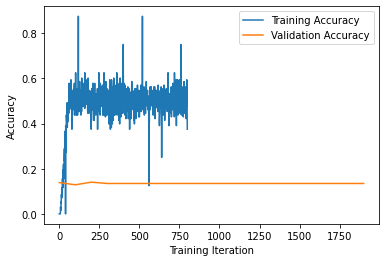

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies)), training_accuracies, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies)))), validation_accuracies, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()